# Import der CSV Dateien
- Repräsentative Profile
- PV-Ertrag

In [128]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt

#from google.colab import files
#uploaded = files.upload()

#------

# Einlesen der Lastprofile
# Zuerst die hochgeladene Datei als Bytes laden
#data = uploaded['Repraesentative_Profile_VDEW.xls']
# Verwenden von read_excel, da es sich um eine Excel-Datei handelt
df_lastprofil = pd.read_excel('Repraesentative_Profile_VDEW.xls', sheet_name='H0')
df_lastprofil.columns = ['Uhrzeit', 'Winter_Samstag', 'Winter_Sonntag', 'Winter_Werktag', 'Sommer_Samstag', 'Sommer_Sonntag', 'Sommer_Werktag', 'Uebergang_Samstag','Uebergang_Sonntag','Uebergang_Werktag']

# Einlesen der PV-Daten
df_pv = pd.read_csv('Timeseries_51.160_10.436_SA2_10kWp_crystSi_14_41deg_-3deg_2020_2020_clean.csv', delimiter=',', header=None)
# Zeit-String zu Datetime Objekt umwandeln
df_pv[0] = pd.to_datetime(df_pv[0], format='%Y%m%d:%H%M')
df_pv = df_pv.set_index(0)
# Upsamplen der Stündlichen Daten mit Faktor 4 auf 15 Minuten
df_pv = df_pv.resample('15min').mean().interpolate(method='linear')

#------

# Erstellen des gesamt DataFrames mit allen Infos
df_base = pd.DataFrame()
#df_base.index = df_pv.index
df_base.insert(0,"Uhrzeit", df_pv.index)

df_base.insert(1,"PV_Ertrag", df_pv[1].values)
# Kompensieren des Upsamplings um den Faktor 4
df_base.loc[:,'PV_Ertrag'] *= 0.25

df_base.insert(2, "Lastprofil", np.nan)
df_base.insert(3, "Day_Type", np.nan)
df_base.insert(4, "Saison", np.nan)





# Zuordnung des Lastprofils zum PV-Ertrag


- Winter: 22.12. - 19.3.
- Frühling: 20.3. - 20.6.
- Sommer: 21.6. - 22.9.
- Herbst: 23.9. - 20.12.

Quellen für Jahreszeiten:

Deutscher Wetterdienst: https://www.dwd.de/DE/service/lexikon/Functions/glossar.html;jsessionid=DEDCDE47025D27F9A5F73783EA838D29.live21063?lv2=101304&lv3=101324






In [129]:
from datetime import datetime

#
def get_season(date):
    """
    Diese Funktion ordnet ein gegebenes Datum den Jahreszeiten Winter, Uebergang und Herbst zu.

    Parameter:
    date (pd.Timestamp): Das Datum, das zugeordnet werden soll.

    Rückgabe:
    str: Die Jahreszeit ('Winter', 'Uebergang', 'Sommer').
    """
    # !!!
    # Muss auf Jahr der verarbeiteten Daten passen
    # !!!
    year = 2020

    # Definieren der Start- und Enddaten der Jahreszeiten
    winter_start = pd.Timestamp(year=year, month=12, day=22)
    winter_end = pd.Timestamp(year=year, month=3, day=19)
    fruehling_start = pd.Timestamp(year=year, month=3, day=20)
    fruehling_end = pd.Timestamp(year=year, month=6, day=20)
    sommer_start = pd.Timestamp(year=year, month=6, day=21)
    sommer_end = pd.Timestamp(year=year, month=9, day=22)
    herbst_start = pd.Timestamp(year=year, month=9, day=23)
    herbst_end = pd.Timestamp(year=year, month=12, day=21)

    if (date >= winter_start) or (date < fruehling_start):
        return 'Winter'
    elif (date >= fruehling_start) and (date < sommer_start):
        return 'Uebergang'
    elif (date >= sommer_start) and (date < herbst_start):
        return 'Sommer'
    elif (date >= herbst_start) and (date < winter_start):
        return 'Uebergang'
    else:
        return 'Unknown'

# Mapping der Wochentage auf die Tagestypen des Lastprofils
def get_day_type(day):
  day_mapping = {
        'Monday': 'Werktag',
        'Tuesday': 'Werktag',
        'Wednesday': 'Werktag',
        'Thursday': 'Werktag',
        'Friday': 'Werktag',
        'Saturday': 'Samstag',
        'Sunday': 'Sonntag'
    }

  # Überprüfen, ob die Eingaben gültig sind
  if day not in day_mapping:
      raise ValueError("Ungültiger Wochentag: {}".format(day))
  # Erstellen des passenden Strings
  day_type = day_mapping[day]

  return day_type

# Funktion zur zeitlichen Zuordnung des Lastprofils auf den PV-Ertrag
def get_time_index(time_str):
    # Definieren der Zeitintervalle
    time_intervals = [
        "00:15:00", "00:30:00", "00:45:00", "01:00:00", "01:15:00", "01:30:00",
        "01:45:00", "02:00:00", "02:15:00", "02:30:00", "02:45:00", "03:00:00", "03:15:00",
        "03:30:00", "03:45:00", "04:00:00", "04:15:00", "04:30:00", "04:45:00",
        "05:00:00", "05:15:00", "05:30:00", "05:45:00", "06:00:00", "06:15:00", "06:30:00",
        "06:45:00", "07:00:00", "07:15:00", "07:30:00", "07:45:00", "08:00:00", "08:15:00",
        "08:30:00", "08:45:00", "09:00:00", "09:15:00", "09:30:00", "09:45:00",
        "10:00:00", "10:15:00", "10:30:00", "10:45:00", "11:00:00", "11:15:00", "11:30:00",
        "11:45:00", "12:00:00", "12:15:00", "12:30:00", "12:45:00", "13:00:00", "13:15:00",
        "13:30:00", "13:45:00", "14:00:00", "14:15:00", "14:30:00", "14:45:00",
        "15:00:00", "15:15:00", "15:30:00", "15:45:00", "16:00:00", "16:15:00", "16:30:00",
        "16:45:00", "17:00:00", "17:15:00", "17:30:00", "17:45:00", "18:00:00", "18:15:00",
        "18:30:00", "18:45:00", "19:00:00", "19:15:00", "19:30:00", "19:45:00",
        "20:00:00", "20:15:00", "20:30:00", "20:45:00", "21:00:00", "21:15:00", "21:30:00",
        "21:45:00", "22:00:00", "22:15:00", "22:30:00", "22:45:00", "23:00:00", "23:15:00",
        "23:30:00", "23:45:00", "00:00:00"
    ]

    time_str = time_str.strftime('%H:%M:%S')

    # Rückgabe des Index
    # Für alle 15 Minuten ein Wert: 24 * 4 = 96
    # -1, da erster und letzter Wert gleich
    return (time_intervals.index(time_str) % 96) + 2  # Anpassung des Index

# Funktion um Last zu Saison, Tag und Uhrzeit abzufragen
def get_load(season_with_daytype, time_index):
  return df_lastprofil[season_with_daytype][time_index]

# Methode zum erstellen der weiteren benötigten Tabellenspalten
def add_columns(table):
  table.insert(5, "Ladestand_Hausbatterie_relativ", np.nan)
  table.insert(6, "Ladestand_Hausbatterie_absolut", np.nan)
  table.insert(7, "Stromfluss_Hausbatterie", np.nan)
  table.insert(8, "Einspeisung", 0.0)
  table.insert(9, "Netzbezug", 0.0)
  table.insert(10, "Geladen_Fahrzeug", 0.0)
  table.insert(11, "Geladen_Fahrzeug_Batterie", 0.0)

  return table

In [130]:
# Schreiben der Lastprofile
for i in df_base.index:
  day = df_base['Uhrzeit'][i].day_name()
  season = get_season(df_base['Uhrzeit'][i])
  day_type = get_day_type(day)
  combined = f"{season}_{day_type}"
  time = df_base['Uhrzeit'].loc[i].time()
  timeindex = get_time_index(time)

  # Schreiben der Werte Lastwerte in Gesamt_Tabelle
  df_base.loc[i, 'Lastprofil'] = get_load(combined, timeindex)
  # Schreiben des Tagestyps und der Saison in die Gesamt_Tabelle
  df_base.loc[i, 'Day_Type'] = day_type
  df_base.loc[i, 'Saison'] = season

C:\Users\remoti\AppData\Local\Temp\ipykernel_8988\2062302240.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Werktag' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_base.loc[i, 'Day_Type'] = day_type
C:\Users\remoti\AppData\Local\Temp\ipykernel_8988\2062302240.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Winter' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_base.loc[i, 'Saison'] = season


# Helper für Ladevorgang

In [131]:
# Helper für Hausbatterie
def batterie_prozent(Ladestand_Hausbatterie_absolut, batteriegroesse):
  return Ladestand_Hausbatterie_absolut/batteriegroesse

#------

# Helper für BEV Laden von Hausbatterie
def get_sonnenaufgang(df, i):
  if i > len(df):
    return None
  df_day = df[df['Uhrzeit'].dt.date == df.loc[i,'Uhrzeit'].date()]
  if len(df_day[df_day['PV_Ertrag'] > 200]) > 0:
        i_day = df_day[df_day['PV_Ertrag'] > 200].index[0]
        time_day = df_day.loc[i_day, 'Uhrzeit']
        sonnenaufgang = df[(df['Uhrzeit'] == time_day)].index[0]
  else:
    # Handle the case where no 'PV_Ertrag' is over 200
      sonnenaufgang = None
  # Sonnenaufgang ist in diesem Fall, wenn die PV erstmalig über 200W liefert.
  return sonnenaufgang

def get_Last_bis_Sonnenaufgang(df, i):
  sonnenaufgang = get_sonnenaufgang(df, i)
  if sonnenaufgang == None:
    return 999999
  return df.loc[i:sonnenaufgang, 'Lastprofil'].sum()

def get_Ertrag_minus_Last_bis_Sonnenaufgang_tomorrow(df, i):
  sonnenaufgang = get_sonnenaufgang(df, i)
  if sonnenaufgang == None:
    return 0
  if i+96 < len(df):
    sonnenaufgang_tomorrow = get_sonnenaufgang(df, i+96)
  else:
    return 0
  last = df.loc[sonnenaufgang:sonnenaufgang_tomorrow, 'Lastprofil'].sum()
  ertrag = df.loc[sonnenaufgang:sonnenaufgang_tomorrow, 'PV_Ertrag'].sum()
  return ertrag - last

#------

# Helper für BEV-Anwesenheit
def ist_auto_zu_hause(current_datetime, nutzungstyp):
    # Extrahiere Wochentag, Stunde und Minute aus dem aktuellen Datum
    wochentag = current_datetime.weekday()  # Montag = 0, Sonntag = 6
    stunde = current_datetime.hour
    minute = current_datetime.minute

    if nutzungstyp == 'Vollzeitkraft':
      # Arbeitswoche: Montag - Freitag
      # Zusätzliche Nutzung: Dienstag & Donnerstag
      if (wochentag == 1 or wochentag == 3) and 16 <= stunde < 19:
              return False  # Auto ist in zusätzlicher Nutzung
      elif 0 <= wochentag <= 4:
          # Arbeitszeit: 07:00 Uhr - 17:00 Uhr + Arbeitsweg
          if 6 <= stunde < 17:
              # Berücksichtige den Arbeitsweg (je 0,5 Stunden einfach)
              if (stunde == 6 and minute < 30) or (stunde == 17 and minute >= 30):
                  return True  # Auto ist zu Hause
              else:
                  return False  # Auto ist bei der Arbeit
          # Zusätzliche Nutzung: Dienstag und Donnerstag, 16:00 Uhr - 19:00 Uhr
          else:
              return True  # Auto ist zu Hause
      # Nutzung am Wochenende: insgesamt 2,0 Stunden
      elif wochentag == 5:
          # Hier müssen wir Annahmen treffen, wann die Nutzung am Wochenende stattfindet.
          # Zum Beispiel könnten wir annehmen, dass die Nutzung zwischen 10:00 und 12:00 Uhr ist.
          # Hier könnte z.B. der Samstagseinkauf statt finden.
          if 10 <= stunde < 12:
              return False  # Auto ist in Nutzung
          else:
              return True  # Auto ist zu Hause
      else:
          return True  # Standardannahme: Auto ist zu Hause
    elif nutzungstyp == 'Teilzeitkraft':
      # Arbeitswoche: Montag - Freitag
      # Zusätzliche Nutzung: Mittwoch
      if (wochentag == 2) and 19 <= stunde < 21:
              return False  # Auto ist in zusätzlicher Nutzung
      elif 0 <= wochentag <= 4:
          # Arbeitszeit: 08:00 Uhr - 13:00 Uhr + Arbeitsweg
          if 7 <= stunde < 14:
              # Berücksichtige den Arbeitsweg (je 0,25 Stunden einfach)
              if (stunde == 7 and minute < 45) or (stunde == 13 and minute >= 15):
                  return True  # Auto ist zu Hause
              else:
                  return False  # Auto ist bei der Arbeit
          # Zusätzliche Nutzung: Dienstag und Donnerstag, 16:00 Uhr - 19:00 Uhr
          else:
              return True  # Auto ist zu Hause
      # Nutzung am Wochenende: insgesamt 2,0 Stunden
      elif wochentag == 5:
          # Hier müssen wir Annahmen treffen, wann die Nutzung am Wochenende stattfindet.
          # Zum Beispiel könnten wir annehmen, dass die Nutzung zwischen 10:00 und 12:00 Uhr ist.
          # Hier könnte z.B. der Samstagseinkauf statt finden.
          if 10 <= stunde < 12:
              return False  # Auto ist in Nutzung
          else:
              return True  # Auto ist zu Hause
      else:
          return True  # Standardannahme: Auto ist zu Hause
    elif nutzungstyp == 'Wochenendpendler':
      # Arbeitswoche: Montag - Freitag
      if (0 <= wochentag <= 4):
              return False  # Auto ist unter der Woche nicht Zuhause
      # Wochenende ohne Zusatznutzung
      elif wochentag == 5:
          # Hier müssen wir Annahmen treffen, wann die Nutzung am Wochenende stattfindet.
          # Zum Beispiel könnten wir annehmen, dass die Nutzung zwischen 10:00 und 12:00 Uhr ist.
          # Hier könnte z.B. der Samstagseinkauf statt finden.
          if 10 <= stunde < 12:
              return False  # Auto ist in Nutzung
          else:
              return True  # Auto ist zu Hause
      else:
          return True
    else:
      print("Ungültiger Nutzungstyp angegeben.")
      return -1  # Fehler ist aufgetreten

# Funktionen zum Überschussladen

In [134]:
# df_base als pv_und_lastdaten
# Berechnung über Zeitserie mit 15 Minuten Schritten
# Alle Einheiten in Wh

# fahrzeuganwesenheit zusätzlich noch mit übergeben?
def ueberschussladen(pv_und_lastdaten, pv_leistung, batteriegroesse, laden_von_batterie, nutzungstyp):

  akkusoll = 0.8
  gesamtdaten = pv_und_lastdaten.copy()
  gesamtdaten = add_columns(gesamtdaten)

  # Erste Zeile manuell beschreiben mit Ladestand etc
  # Berechnung würde für erste Zeile micht funktionieren, da es keine Zeile davor gibt aus der Werte übernommen werden können

  # Komplette Spalte mit PV-Daten wird mit gewünschter Leistung multipliziert
  gesamtdaten.loc[:,'PV_Ertrag'] *= (pv_leistung/10000)

  gesamtdaten.loc[0,'Einspeisung'] = 0
  gesamtdaten.loc[0,'Netzbezug'] = 0
  gesamtdaten.loc[0,'Geladen_Fahrzeug'] = 0

  gesamtdaten.loc[0, 'Ladestand_Hausbatterie_absolut'] = 0.7 * batteriegroesse
  gesamtdaten.loc[0, 'Ladestand_Hausbatterie_relativ'] = batterie_prozent(gesamtdaten['Ladestand_Hausbatterie_absolut'][0], batteriegroesse)

  # Fahrzeuganwesenheit muss hier noch auf Tabelle angewendet werden
  # Berechnung der Zeilen 1 - x (0 wurde zuvor befüllt)
  for i in range(1, len(gesamtdaten)-1):
    #print(gesamtdaten.iloc[i-1])
    #print("PV_Leistung: "+str(pv_leistung))
    #print("Batteriegroesse: "+str(batteriegroesse))
  #if # auserhalb der Zeiten in denen der Akku verladen werden soll.
    if gesamtdaten.loc[i,'PV_Ertrag'] > gesamtdaten.loc[i,'Lastprofil']:
      # Prüfen ob Hausakku schon gewünschten Ladezustand hat
      if (gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_relativ'] < akkusoll) and ((gesamtdaten.loc[i,'PV_Ertrag']-gesamtdaten.loc[i,'Lastprofil']) <= (batteriegroesse - gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_absolut'])):
          # Multiplikation mit 0,85 für Ladeverluste im Gesamtprozess der Batterienutzung
          gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'] = (gesamtdaten.loc[i,'PV_Ertrag']-gesamtdaten.loc[i,'Lastprofil'])*0.85 + gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_absolut']
          gesamtdaten.loc[i,'Ladestand_Hausbatterie_relativ'] = batterie_prozent(gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'], batteriegroesse)
          #print('----Batterie geladen----')
      # ist noch so viel platz im Akku, dass Strom komplett verladen werden kann?
      # Sonst prüfen ob Strom stark genug zum Überschuss laden und Auto angeschlossen
      elif ist_auto_zu_hause(df_base.loc[i,'Uhrzeit'], nutzungstyp):
        gesamtdaten.loc[i,'Geladen_Fahrzeug'] = gesamtdaten.loc[i,'PV_Ertrag'] - gesamtdaten.loc[i,'Lastprofil']
        gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'] = gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_absolut']
        gesamtdaten.loc[i,'Ladestand_Hausbatterie_relativ'] = batterie_prozent(gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'], batteriegroesse)
        #print('----Auto geladen----')
        # Leistung muss hochgerechnet werden ob

      # Wenn nicht, dann einfach einspeisen
      else:
        gesamtdaten.loc[i,'Einspeisung'] = gesamtdaten.loc[i,'PV_Ertrag'] - gesamtdaten.loc[i,'Lastprofil']
        gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'] = gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_absolut']
        gesamtdaten.loc[i,'Ladestand_Hausbatterie_relativ'] = batterie_prozent(gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'], batteriegroesse)
        #print('----Eingespeist----')

  # Wenn kein PV Ertrag vorhanden, aber Batterie noch mit genügend Ladung erst Strom aus Batterie für Haushalt verwenden
    elif gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_absolut'] >= float(gesamtdaten.loc[i,'Lastprofil']):
      gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'] = gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_absolut'] - gesamtdaten.loc[i,'Lastprofil']
      gesamtdaten.loc[i,'Ladestand_Hausbatterie_relativ'] = batterie_prozent(gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'], batteriegroesse)
      #print('----Batterie entladen----')
  # Sonst Strom aus Netz beziehen
    else:
      gesamtdaten.loc[i,'Netzbezug'] = gesamtdaten.loc[i,'Lastprofil']
      gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'] = gesamtdaten.loc[i-1,'Ladestand_Hausbatterie_absolut']
      gesamtdaten.loc[i,'Ladestand_Hausbatterie_relativ'] = batterie_prozent(gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'], batteriegroesse)
      #print('----Netzbezug----')
  # Wenn Laden mit Batterieüberschuss aktiviert ist:
    if laden_von_batterie and gesamtdaten.loc[i, 'Uhrzeit'].hour == 4 and gesamtdaten.loc[i, 'Uhrzeit'].minute == 00 and ist_auto_zu_hause(df_base.loc[i,'Uhrzeit'], nutzungstyp):
      # 4 h vor Sonnenaufgang erster Check ob in Batterie Überschuss zum Verladen ist
      if get_sonnenaufgang(gesamtdaten, i) != None:
        if (get_Ertrag_minus_Last_bis_Sonnenaufgang_tomorrow(gesamtdaten, i)+ gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut']) > 0:
          if get_Last_bis_Sonnenaufgang(gesamtdaten, i) < gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut']:
            gesamtdaten.loc[i,'Geladen_Fahrzeug_Batterie'] = gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'] - get_Last_bis_Sonnenaufgang(gesamtdaten, i)
            gesamtdaten.loc[i,'Ladestand_Hausbatterie_absolut'] -= gesamtdaten.loc[i,'Geladen_Fahrzeug_Batterie']

  return gesamtdaten



# Berechnung für Vollzeitkraft

In [135]:
# Dictionary zur Speicherung der DataFrames
df_dict_vollzeit = {}
df_dict_vollzeit_bat = {}

# Schleife für die verschiedenen Wertebereiche
for pv_leistung in range(5000, 20001, 5000):
    for batteriegroesse in range(5000, 20001, 5000):
        df_result = ueberschussladen(df_base, pv_leistung, batteriegroesse, False, 'Vollzeitkraft')
        key = f'pv{pv_leistung}_bat{batteriegroesse}'
        df_dict_vollzeit[key] = df_result

# Schleife für die verschiedenen Wertebereiche
for pv_leistung in range(5000, 20001, 5000):
    for batteriegroesse in range(5000, 20001, 5000):
        df_result = ueberschussladen(df_base, pv_leistung, batteriegroesse, True, 'Vollzeitkraft')
        key = f'pv{pv_leistung}_bat{batteriegroesse}'
        df_dict_vollzeit_bat[key] = df_result

# Berechnung für Teilzeitkraft

In [136]:
df_dict_teilzeit = {}
df_dict_teilzeit_bat = {}

# Schleife für die verschiedenen Wertebereiche
for pv_leistung in range(5000, 20001, 5000):
    for batteriegroesse in range(5000, 20001, 5000):
        df_result = ueberschussladen(df_base, pv_leistung, batteriegroesse, False, 'Teilzeitkraft')
        key = f'pv{pv_leistung}_bat{batteriegroesse}'
        df_dict_teilzeit[key] = df_result

# Schleife für die verschiedenen Wertebereiche
for pv_leistung in range(5000, 20001, 5000):
    for batteriegroesse in range(5000, 20001, 5000):
        df_result = ueberschussladen(df_base, pv_leistung, batteriegroesse, True, 'Teilzeitkraft')
        key = f'pv{pv_leistung}_bat{batteriegroesse}'
        df_dict_teilzeit_bat[key] = df_result

# Berechnung für Wochenendpendler

In [137]:
df_dict_wochenend = {}
df_dict_wochenend_bat = {}

# Schleife für die verschiedenen Wertebereiche
for pv_leistung in range(5000, 20001, 5000):
    for batteriegroesse in range(5000, 20001, 5000):
        df_result = ueberschussladen(df_base, pv_leistung, batteriegroesse, False, 'Wochenendpendler')
        key = f'pv{pv_leistung}_bat{batteriegroesse}'
        df_dict_wochenend[key] = df_result

# Schleife für die verschiedenen Wertebereiche
for pv_leistung in range(5000, 20001, 5000):
    for batteriegroesse in range(5000, 20001, 5000):
        df_result = ueberschussladen(df_base, pv_leistung, batteriegroesse, True, 'Wochenendpendler')
        key = f'pv{pv_leistung}_bat{batteriegroesse}'
        df_dict_wochenend_bat[key] = df_result

# Plot der Ladestrategien

[np.float64(544.13735), np.float64(742.3230409374999), np.float64(1186.24487890625), np.float64(1479.0506203125003), np.float64(1770.0423040624999), np.float64(2133.0143506249997), np.float64(2819.33317125), np.float64(3480.3034068750003), np.float64(3089.4149395312497), np.float64(3547.5977984375), np.float64(4362.1129371875), np.float64(5159.105635156251), np.float64(4432.621428750001), np.float64(4982.795125), np.float64(5841.25338), np.float64(6690.6690262500015)]
[np.float64(1077.0228375), np.float64(1214.1301034375), np.float64(1562.3733789062499), np.float64(1734.3793703125002), np.float64(3248.0071853125), np.float64(3502.0355631249995), np.float64(4140.04624625), np.float64(4742.361413125), np.float64(5786.73348328125), np.float64(5867.781382812501), np.float64(6603.9951715625), np.float64(7327.354222656251), np.float64(8400.32275375), np.float64(8414.3334125), np.float64(9013.93408), np.float64(9809.297726249999)]


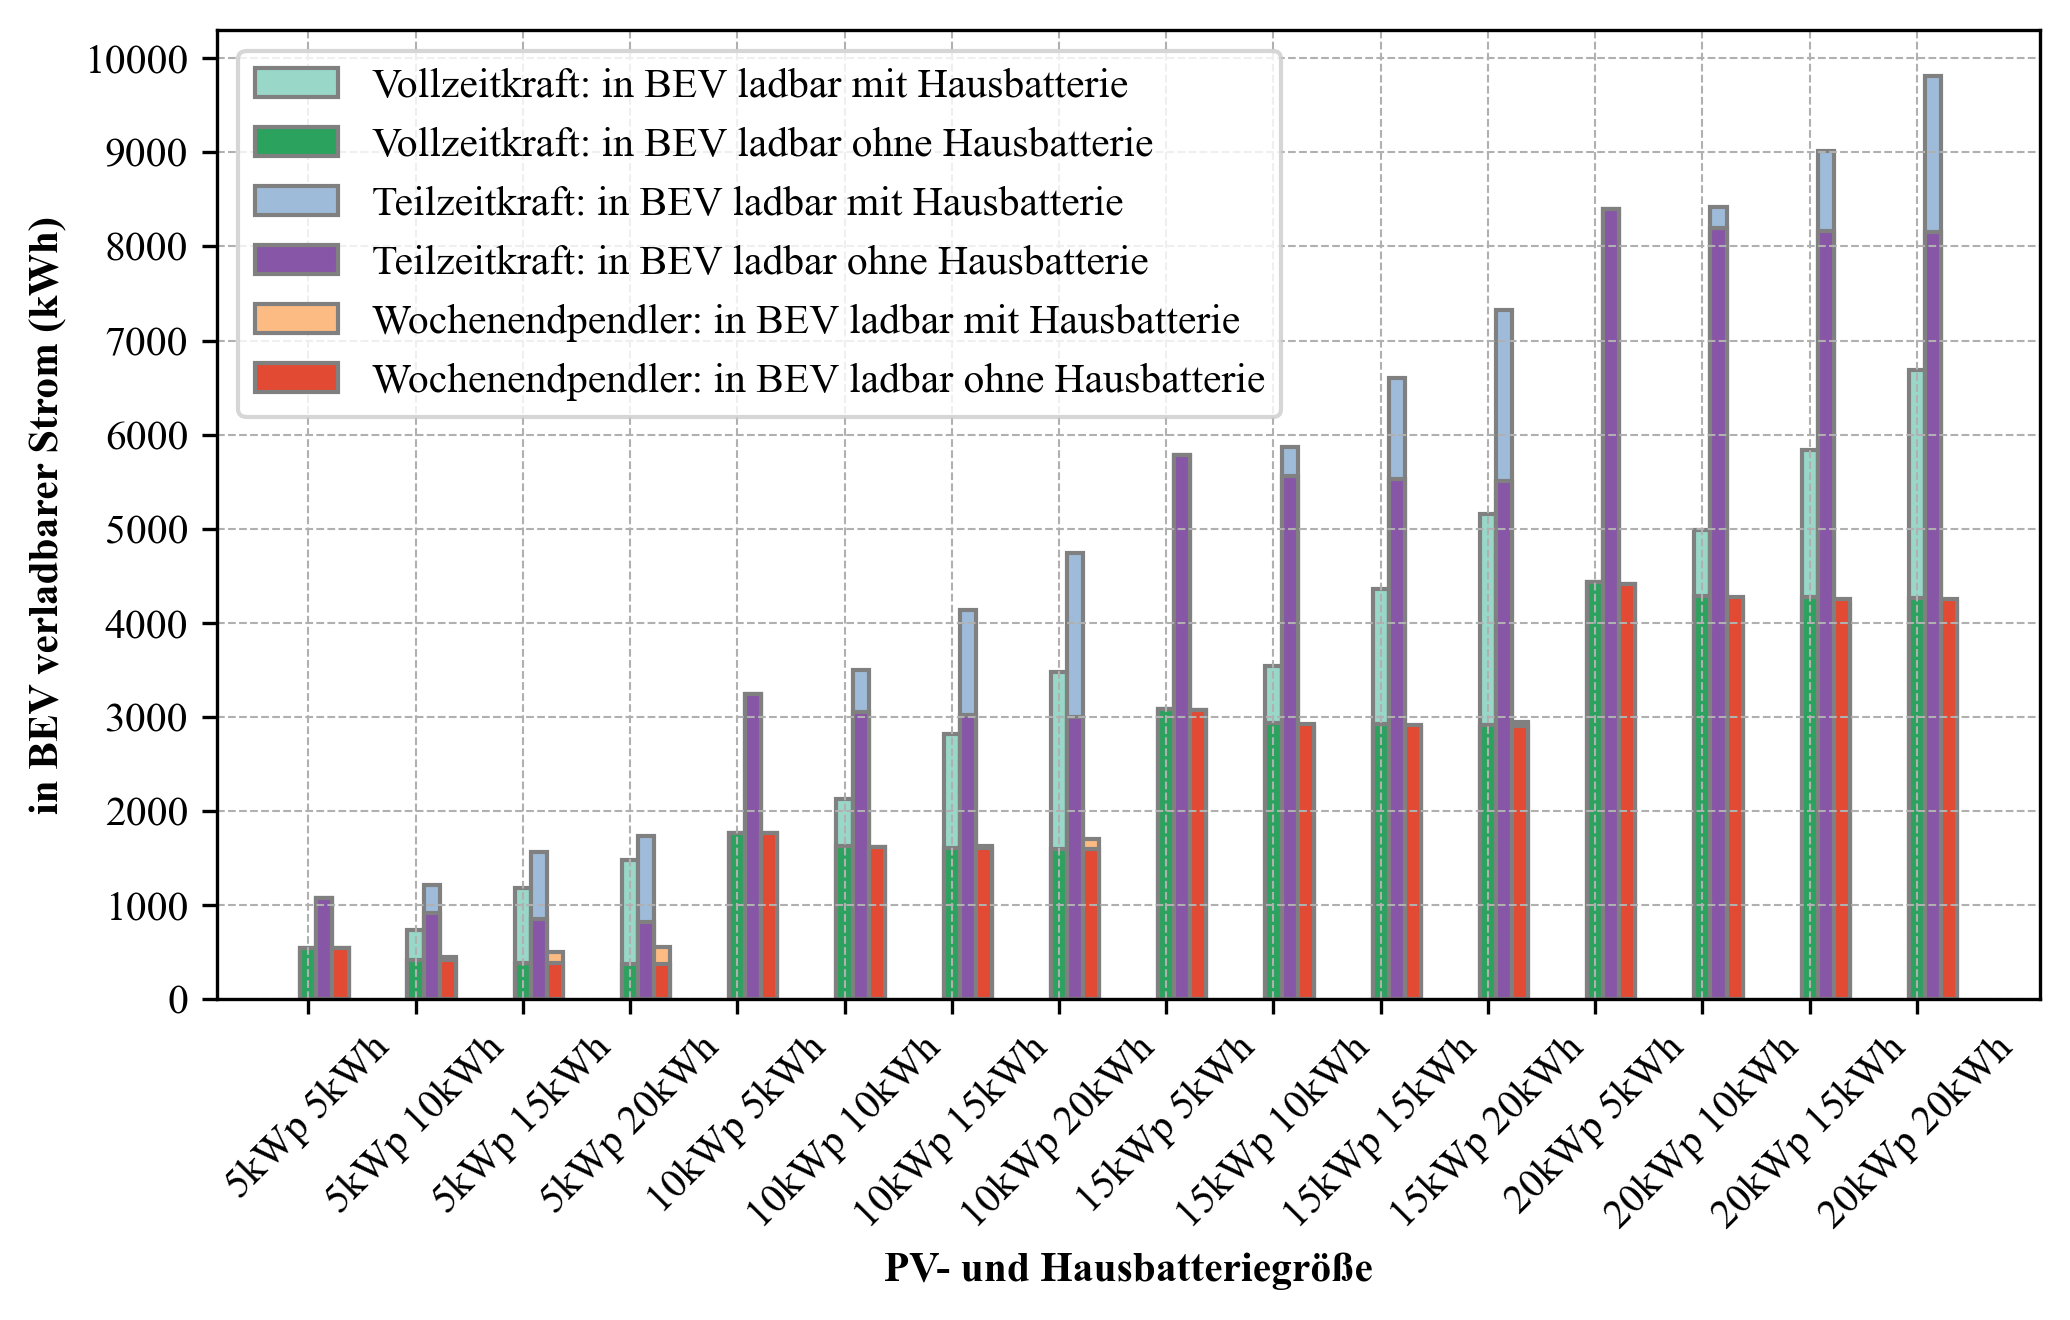

In [167]:
from operator import ge
def plot_pv_battery_sums_comparison(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat):
    # Schriftart an Arbeit anpassen
    # font = {'fontname':'helvet'}

    # Initialisierung der Summen
    pv_sum = []

    einspeisung_sum_vollzeit = []
    einspeisung_sum_teilzeit = []
    einspeisung_sum_wochenend = []

    netzbezug_sum_vollzeit = []
    netzbezug_sum_teilzeit = []
    netzbezug_sum_wochenend = []

    geladen_fahrzeug_sum_vollzeit = []
    geladen_fahrzeug_sum_teilzeit = []
    geladen_fahrzeug_sum_wochenend = []

    geladen_fahrzeug_batterie_sum_vollzeit = []
    geladen_fahrzeug_batterie_sum_teilzeit = []
    geladen_fahrzeug_batterie_sum_wochenend = []

    lastprofil_sum = []
    labels = []

    # Berechnung der Summen für jeden DataFrame im Dictionary
    for key, df in df_dict_vollzeit.items():
        # / 1000 Umrechnung von Wh in kWh
        pv_sum.append(df['PV_Ertrag'].sum() / 1000)
        einspeisung_sum_vollzeit.append(df['Einspeisung'].sum() / 1000)
        netzbezug_sum_vollzeit.append(df['Netzbezug'].sum() / 1000)
        geladen_fahrzeug_sum_vollzeit.append(df['Geladen_Fahrzeug'].sum() / 1000)

        lastprofil_sum.append(df['Lastprofil'].sum() / 1000)
        labels.append(key)

    for key, df in df_dict_vollzeit_bat.items():
        geladen_fahrzeug_batterie_sum_vollzeit.append(df['Geladen_Fahrzeug_Batterie'].sum() / 1000 + df['Geladen_Fahrzeug'].sum() / 1000)

    for key, df in df_dict_teilzeit.items():
        # / 1000 Umrechnung von Wh in kWh
        einspeisung_sum_teilzeit.append(df['Einspeisung'].sum() / 1000)
        netzbezug_sum_teilzeit.append(df['Netzbezug'].sum() / 1000)
        geladen_fahrzeug_sum_teilzeit.append(df['Geladen_Fahrzeug'].sum() / 1000)

    for key, df in df_dict_teilzeit_bat.items():
        geladen_fahrzeug_batterie_sum_teilzeit.append(df['Geladen_Fahrzeug_Batterie'].sum() / 1000 + df['Geladen_Fahrzeug'].sum() / 1000)

    for key, df in df_dict_wochenend.items():
        # / 1000 Umrechnung von Wh in kWh
        einspeisung_sum_wochenend.append(df['Einspeisung'].sum() / 1000)
        netzbezug_sum_wochenend.append(df['Netzbezug'].sum() / 1000)
        geladen_fahrzeug_sum_wochenend.append(df['Geladen_Fahrzeug'].sum() / 1000)

    for key, df in df_dict_wochenend_bat.items():
        geladen_fahrzeug_batterie_sum_wochenend.append(df['Geladen_Fahrzeug_Batterie'].sum() / 1000 + df['Geladen_Fahrzeug'].sum() / 1000)

    #print(pv_sum)
    print(geladen_fahrzeug_batterie_sum_vollzeit)
    print(geladen_fahrzeug_batterie_sum_teilzeit)
    #print(lastprofil_sum)

    # Definition der Breite der Balken und Positionen
    bar_width = 0.15
    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r1]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r3]
    r6 = [x + bar_width for x in r5]
    r7 = [x + bar_width for x in r5]
    #r8 = [x + bar_width for x in r5]
    #r9 = [x + bar_width for x in r6]
    #r10 = [x + bar_width for x in r6]

    # Erstellen der Balkendiagramme
    plt.figure(figsize=(7, 4.5))
    #plt.bar(r1, pv_sum, color='#ffffb3', width=bar_width, edgecolor='grey', label='PV_Ertrag')
    # Plot mit Eigenverbrauch etc.
    #plt.bar(r2, lastprofil_sum, color='black', width=bar_width, edgecolor='grey', label='Eigenverbrauch_Haus')
    #plt.bar(r3, -np.array(netzbezug_sum_vollzeit), color='#fb8072', width=bar_width, edgecolor='grey', bottom=lastprofil_sum, label='Netzbezug')
    #plt.bar(r4, einspeisung_sum_vollzeit, color='#80b1d3', width=bar_width, edgecolor='grey', label='Einspeisung')
    #plt.bar(r6, geladen_fahrzeug_batterie_sum_vollzeit, color='#8dd3c7', width=bar_width, edgecolor='grey', label='Geladen_Fahrzeug_Batterie')
    #plt.bar(r5, geladen_fahrzeug_sum_vollzeit, color='#bebada', width=bar_width, edgecolor='grey', label='Geladen_Fahrzeug')
    #plt.bar(r7, einspeisung_sum_vollzeit, color='#80b1d3', width=bar_width, edgecolor='grey', label='Einspeisung_Vollzeit')
    #plt.bar(r8, geladen_fahrzeug_sum_teilzeit, color='#fdb462', width=bar_width, edgecolor='grey', label='Geladen_Teilzeit')
    # Farbe Akku verladen  #8dd3c7
    # Orange: #fdb462

    plt.bar(r3, geladen_fahrzeug_batterie_sum_vollzeit, color='#99d8c9', width=bar_width, edgecolor='grey', label='Vollzeitkraft: in BEV ladbar mit Hausbatterie')
    plt.bar(r2, geladen_fahrzeug_sum_vollzeit, color='#2ca25f', width=bar_width, edgecolor='grey', label='Vollzeitkraft: in BEV ladbar ohne Hausbatterie')

    plt.bar(r5, geladen_fahrzeug_batterie_sum_teilzeit, color='#9ebcda', width=bar_width, edgecolor='grey', label='Teilzeitkraft: in BEV ladbar mit Hausbatterie')
    plt.bar(r4, geladen_fahrzeug_sum_teilzeit, color='#8856a7', width=bar_width, edgecolor='grey', label='Teilzeitkraft: in BEV ladbar ohne Hausbatterie')

    plt.bar(r7, geladen_fahrzeug_batterie_sum_wochenend, color='#fdbb84', width=bar_width, edgecolor='grey', label='Wochenendpendler: in BEV ladbar mit Hausbatterie')
    plt.bar(r6, geladen_fahrzeug_sum_wochenend, color='#e34a33', width=bar_width, edgecolor='grey', label='Wochenendpendler: in BEV ladbar ohne Hausbatterie')

    # Schriftart passend setzen
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    labels = ['5kWp 5kWh', '5kWp 10kWh', '5kWp 15kWh', '5kWp 20kWh', '10kWp 5kWh', '10kWp 10kWh', '10kWp 15kWh', '10kWp 20kWh', '15kWp 5kWh', '15kWp 10kWh', '15kWp 15kWh', '15kWp 20kWh', '20kWp 5kWh', '20kWp 10kWh', '20kWp 15kWh', '20kWp 20kWh']


    # Hinzufügen der Achsenbeschriftungen und Titel
    plt.xlabel('PV- und Hausbatteriegröße', fontweight='bold')
    plt.ylabel('in BEV verladbarer Strom (kWh)', fontweight='bold')
    #plt.title('Ladeprofile bei unterschiedlichen Anlagengrößen')
    plt.xticks([r + bar_width for r in range(len(labels))], labels, rotation=45)
    plt.legend()

    

    # Hinzufügen der Rasterung
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Anpassung der y-Achse Ticks
    y_max = max(max(geladen_fahrzeug_batterie_sum_vollzeit), max(geladen_fahrzeug_batterie_sum_teilzeit), max(geladen_fahrzeug_batterie_sum_wochenend))
    plt.yticks(np.arange(0, y_max + 1000, 1000))

    
    # Anzeige des Plots
    plt.tight_layout()
    plt.show()

plot_pv_battery_sums_comparison(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat)

# PV Monatsvergleich

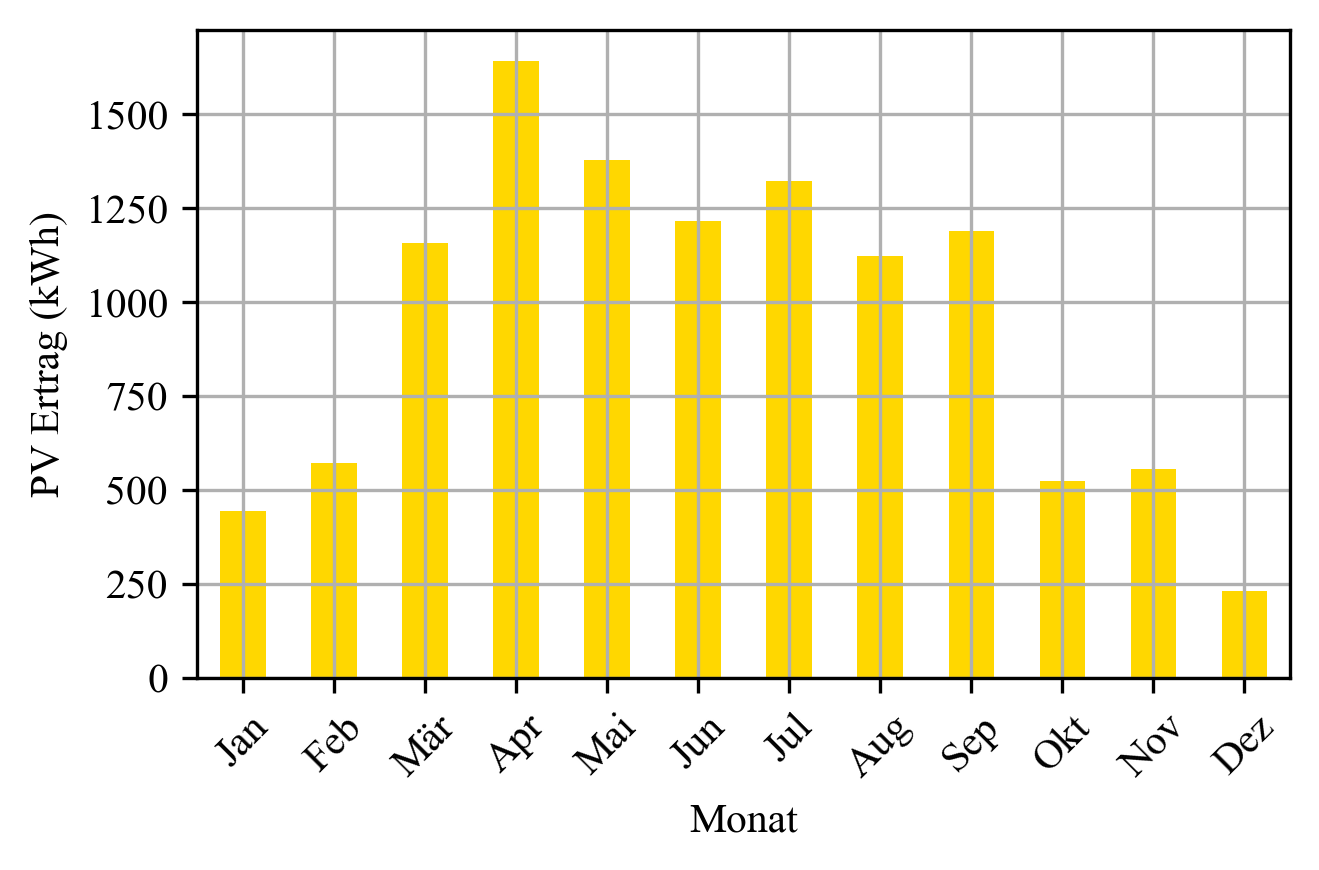

In [ ]:
# import os
def plot_monthly_pv(df, title):
    df = df.copy()
    df['year_month'] = pd.to_datetime(df['Uhrzeit']).dt.to_period('M')

    # Sicherstellen, dass die relevanten Spalten numerisch sind
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Monatliche Summen berechnen
    pv_sum = df.groupby(['year_month'])['PV_Ertrag'].sum() / 1000  # Umrechnung von Wh in kWh
    #print(pv_sum)

    # Schriftart passend setzen
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    labels = ['Jan','Feb','Mär','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez']

    # Plot erstellen
    plt.figure(figsize=(4.5, 3))
    pv_sum.plot(kind='bar', color='gold')
    #plt.title(title)
    plt.xlabel('Monat')
    plt.ylabel('PV Ertrag (kWh)')
    plt.xticks([r for r in range(len(labels))], labels, rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_monthly_pv(df_dict_vollzeit['pv10000_bat10000'], "Monatsvergleich PV-Ertrag")

# Ladevolumen Monatsvergleich

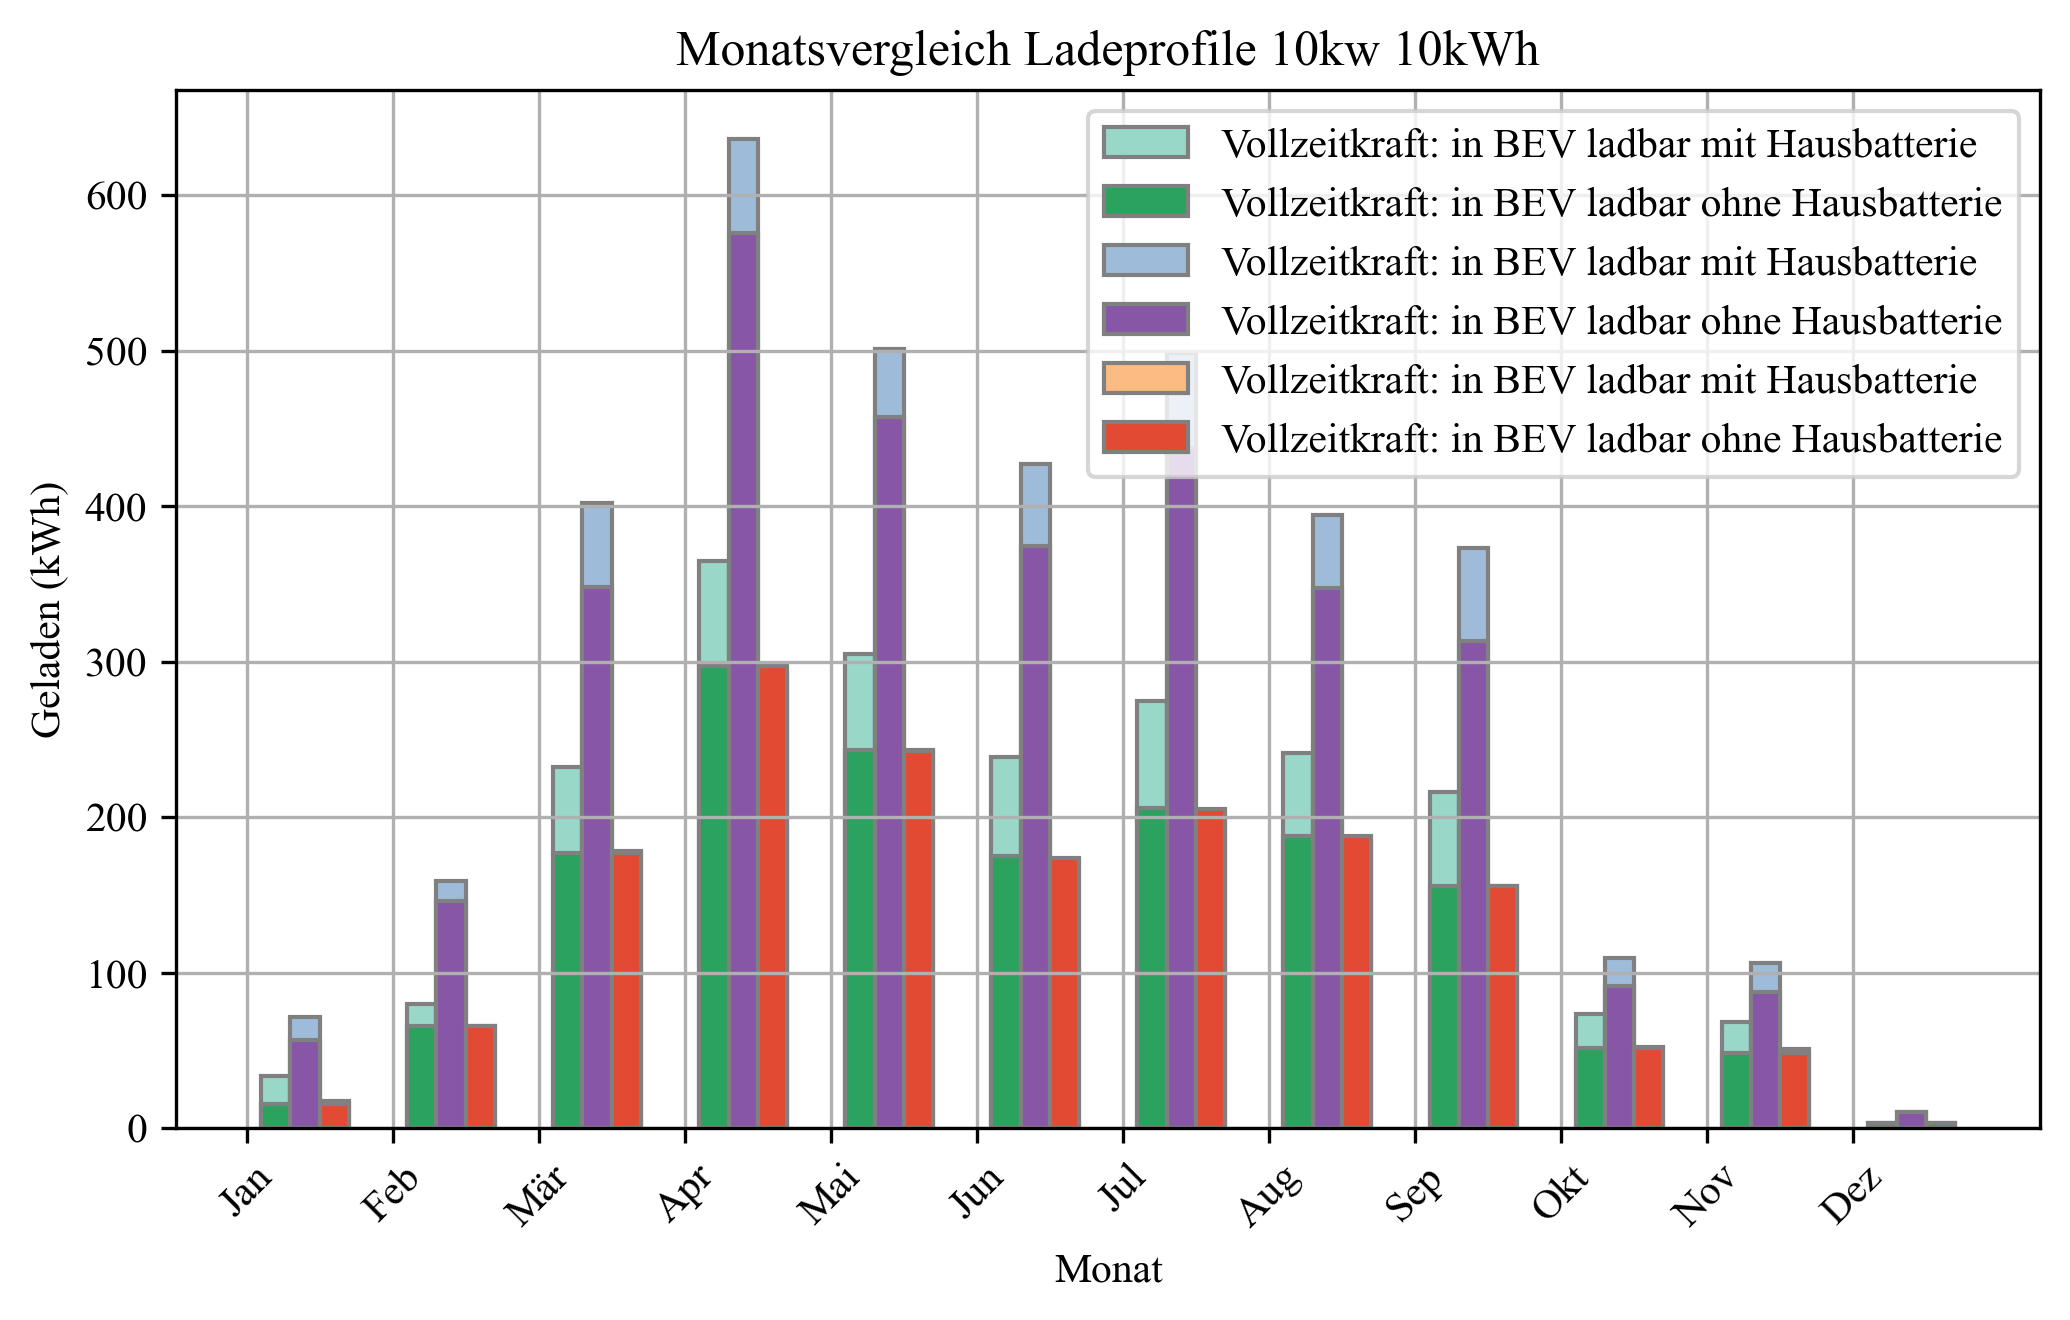

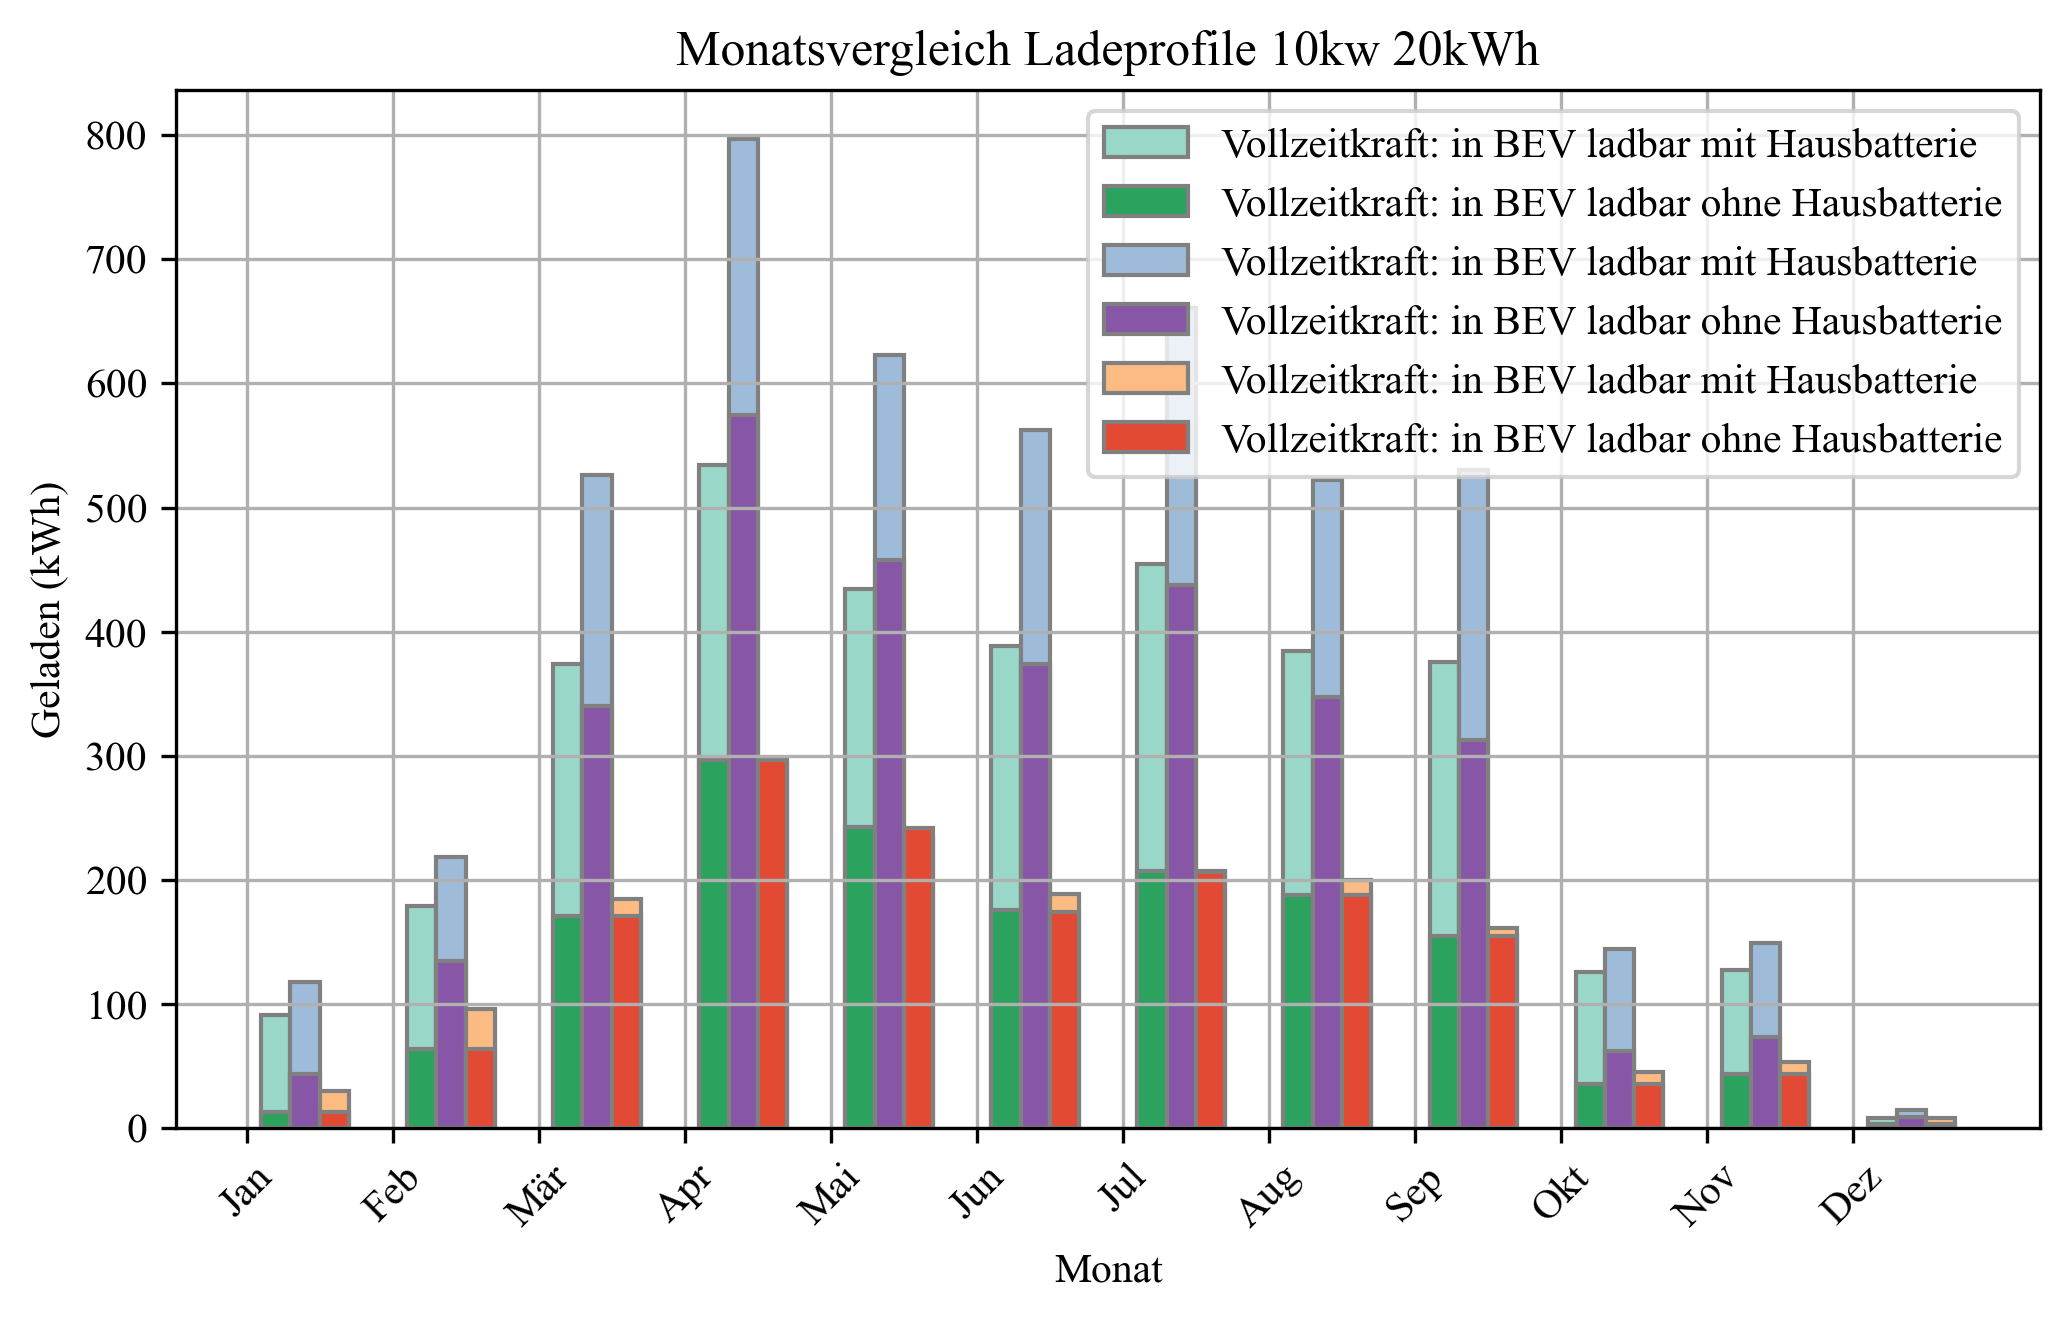

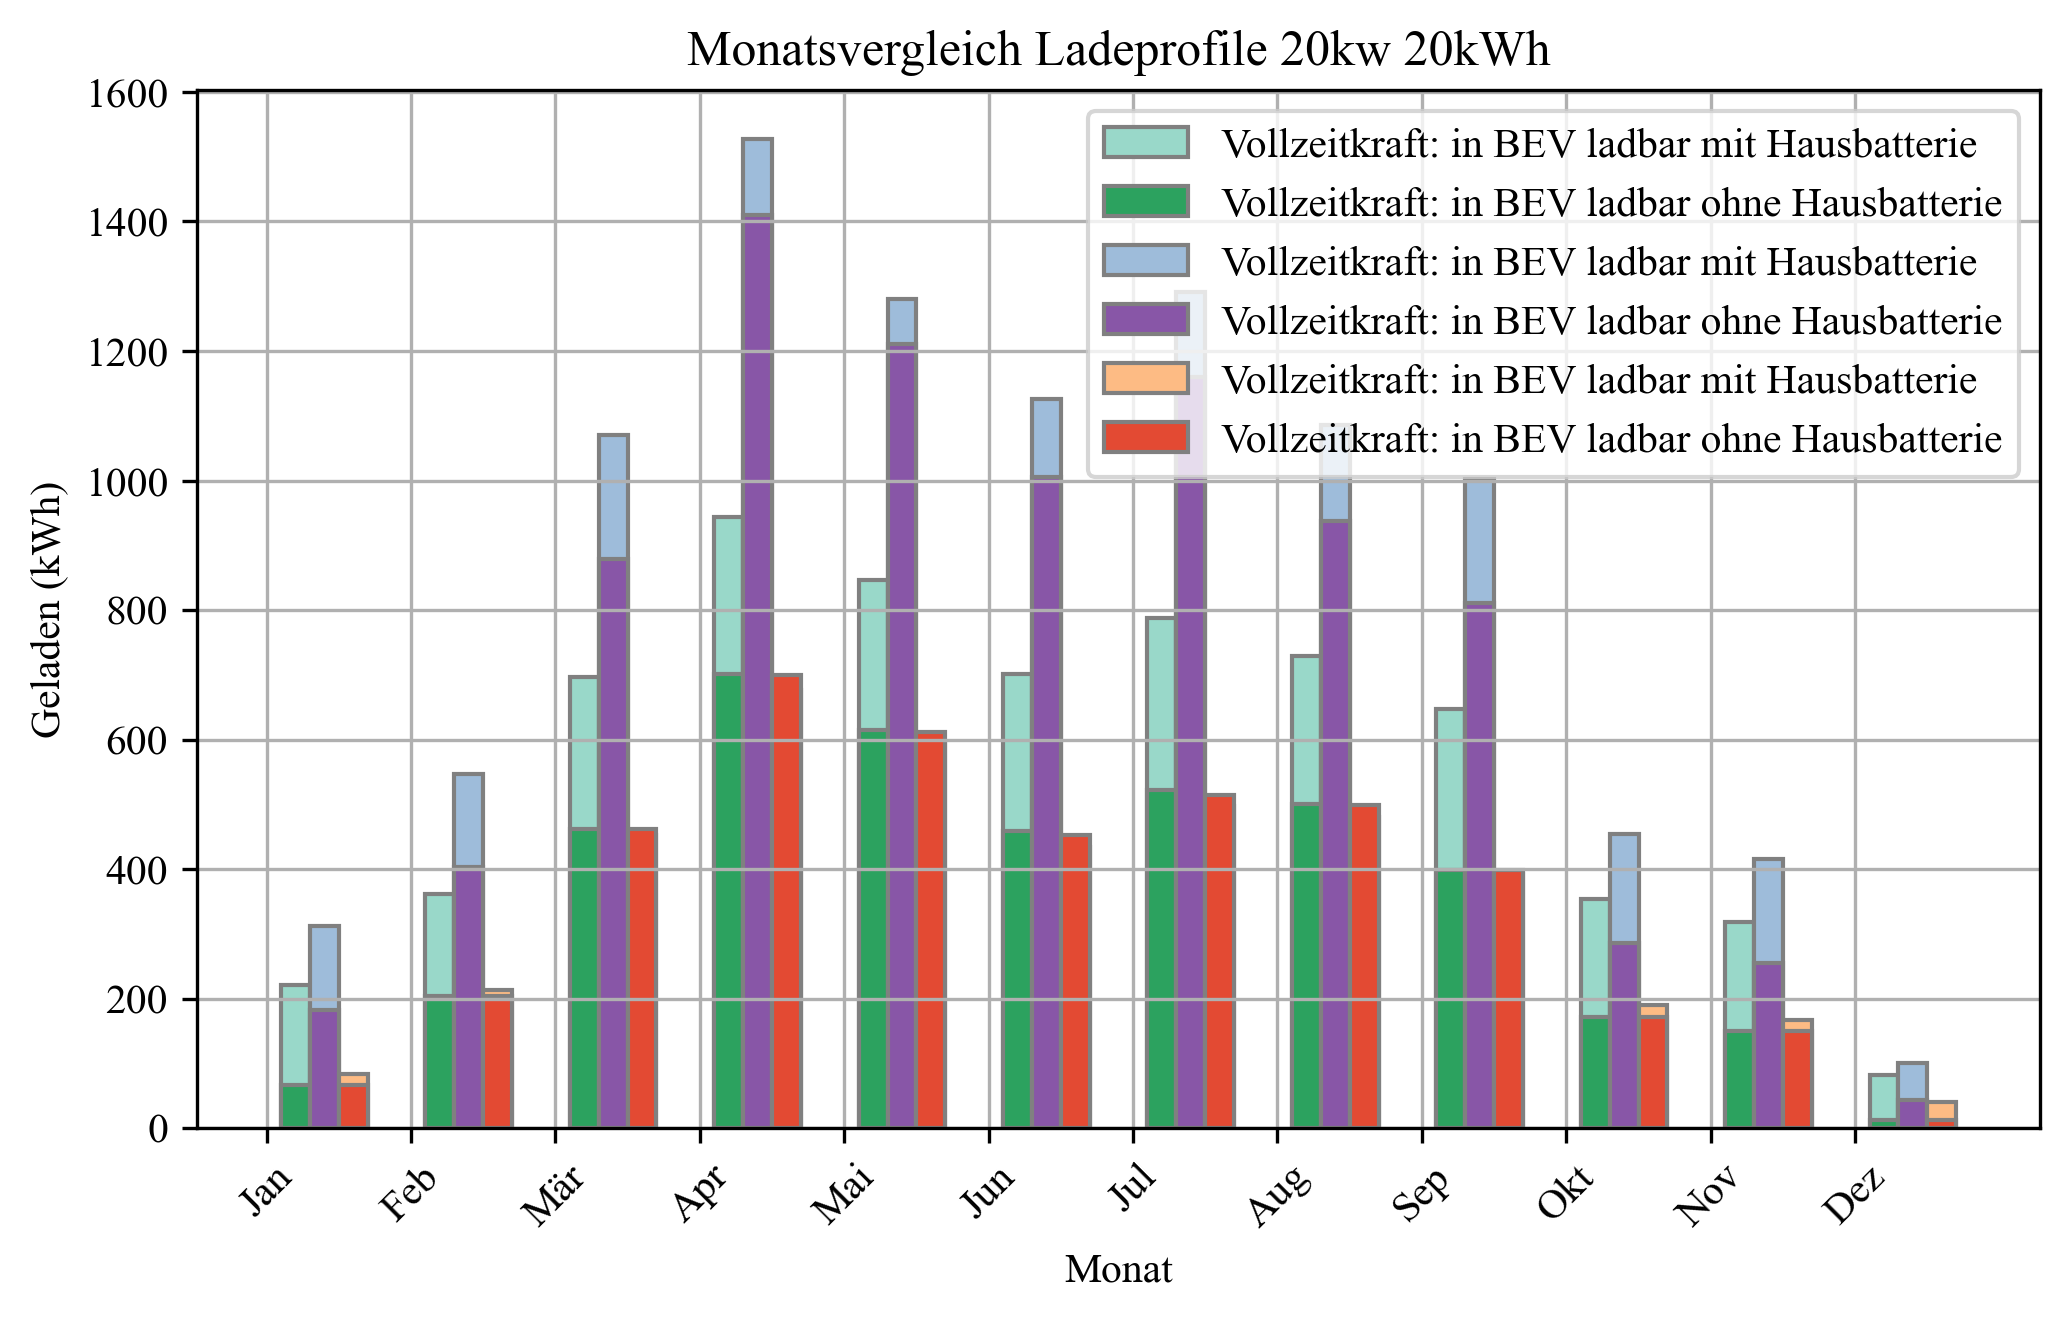

In [ ]:
def plot_monthly_charge(df_dict_vollzeit, df_dict_vollzeit_bat , df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, groese_pv_und_bat, title):
    df_voll = df_dict_vollzeit[groese_pv_und_bat].copy()
    df_voll_battery = df_dict_vollzeit_bat[groese_pv_und_bat].copy()
    df_voll['year_month'] = pd.to_datetime(df_voll['Uhrzeit']).dt.to_period('M')
    df_voll_battery['year_month'] = pd.to_datetime(df_voll_battery['Uhrzeit']).dt.to_period('M')

    df_teil = df_dict_teilzeit[groese_pv_und_bat].copy()
    df_teil_battery = df_dict_teilzeit_bat[groese_pv_und_bat].copy()
    df_teil['year_month'] = pd.to_datetime(df_teil['Uhrzeit']).dt.to_period('M')
    df_teil_battery['year_month'] = pd.to_datetime(df_teil_battery['Uhrzeit']).dt.to_period('M')

    df_woch = df_dict_wochenend[groese_pv_und_bat].copy()
    df_woch_battery = df_dict_wochenend_bat[groese_pv_und_bat].copy()
    df_woch['year_month'] = pd.to_datetime(df_woch['Uhrzeit']).dt.to_period('M')
    df_woch_battery['year_month'] = pd.to_datetime(df_woch_battery['Uhrzeit']).dt.to_period('M')

    # ----

    # Sicherstellen, dass die relevanten Spalten numerisch sind Vollzeit
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_voll[column] = pd.to_numeric(df_voll[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_voll_battery[column] = pd.to_numeric(df_voll_battery[column], errors='coerce')

    # Sicherstellen, dass die relevanten Spalten numerisch sind Teilzeit
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_teil[column] = pd.to_numeric(df_teil[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_teil_battery[column] = pd.to_numeric(df_teil_battery[column], errors='coerce')

    # Sicherstellen, dass die relevanten Spalten numerisch sind Wochenendpendler
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_woch[column] = pd.to_numeric(df_woch[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_woch_battery[column] = pd.to_numeric(df_woch_battery[column], errors='coerce')

    # ---- 
    # Monatliche Summen berechnen
    geladen_voll = df_voll.groupby(['year_month'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_voll_mit_batterie = df_voll_battery.groupby(['year_month'])['Geladen_Fahrzeug'].sum() / 1000 + df_voll_battery.groupby(['year_month'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh
    #print(pv_sum)

    # Monatliche Summen berechnen
    geladen_teil = df_teil.groupby(['year_month'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_teil_mit_batterie = df_teil_battery.groupby(['year_month'])['Geladen_Fahrzeug'].sum() / 1000 + df_teil_battery.groupby(['year_month'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh

    # Monatliche Summen berechnen
    geladen_woch = df_woch.groupby(['year_month'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_woch_mit_batterie = df_woch_battery.groupby(['year_month'])['Geladen_Fahrzeug'].sum() / 1000 + df_woch_battery.groupby(['year_month'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh

    

    plt.figure(figsize=(7, 4.5))

    # Schriftart passend setzen
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'

    bar_width = 0.2
    labels = geladen_voll.index
    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]


    plt.bar(r2, geladen_voll_mit_batterie, color='#99d8c9', width=bar_width, edgecolor='grey', label='Vollzeitkraft: in BEV ladbar mit Hausbatterie')
    plt.bar(r2, geladen_voll, color='#2ca25f', width=bar_width, edgecolor='grey', label='Vollzeitkraft: in BEV ladbar ohne Hausbatterie')

    plt.bar(r3, geladen_teil_mit_batterie, color='#9ebcda', width=bar_width, edgecolor='grey', label='Teilzeitkraft: in BEV ladbar mit Hausbatterie')
    plt.bar(r3, geladen_teil, color='#8856a7', width=bar_width, edgecolor='grey', label='Teilzeitkraft: in BEV ladbar ohne Hausbatterie')

    plt.bar(r4, geladen_woch_mit_batterie, color='#fdbb84', width=bar_width, edgecolor='grey', label='Wochenendpendler: in BEV ladbar mit Hausbatterie')
    plt.bar(r4, geladen_woch, color='#e34a33', width=bar_width, edgecolor='grey', label='Wochenendpendler: in BEV ladbar ohne Hausbatterie')

    labels = ['Jan','Feb','Mär','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez']

    # Plot erstellen
    plt.title(title)
    plt.legend()
    plt.xlabel('Monat')
    plt.ylabel('Geladen (kWh)')
    plt.xticks([r for r in range(len(labels))], labels, rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_monthly_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv10000_bat10000', "Monatsvergleich Ladeprofile 10kw 10kWh")
plot_monthly_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv10000_bat20000', "Monatsvergleich Ladeprofile 10kw 20kWh")
plot_monthly_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv20000_bat10000', "Monatsvergleich Ladeprofile 20kw 10kWh")
plot_monthly_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv20000_bat20000', "Monatsvergleich Ladeprofile 20kw 20kWh")

Vollzeit: Saison
Sommer       632.286875
Uebergang    822.679462
Winter       172.056019
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer        822.682307
Uebergang    1070.169372
Winter        240.162672
dtype: float64 kWh mit Batteriesupport
Teilzeit: Saison
Sommer       1178.055631
Uebergang    1529.235387
Winter        345.082137
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       1351.920569
Uebergang    1741.826366
Winter        408.288628
dtype: float64 kWh mit Batteriesupport
Wochenendpendler: Saison
Sommer       630.956369
Uebergang    821.447000
Winter       172.056019
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       624.794210
Uebergang    819.275158
Winter       174.695793
dtype: float64 kWh mit Batteriesupport


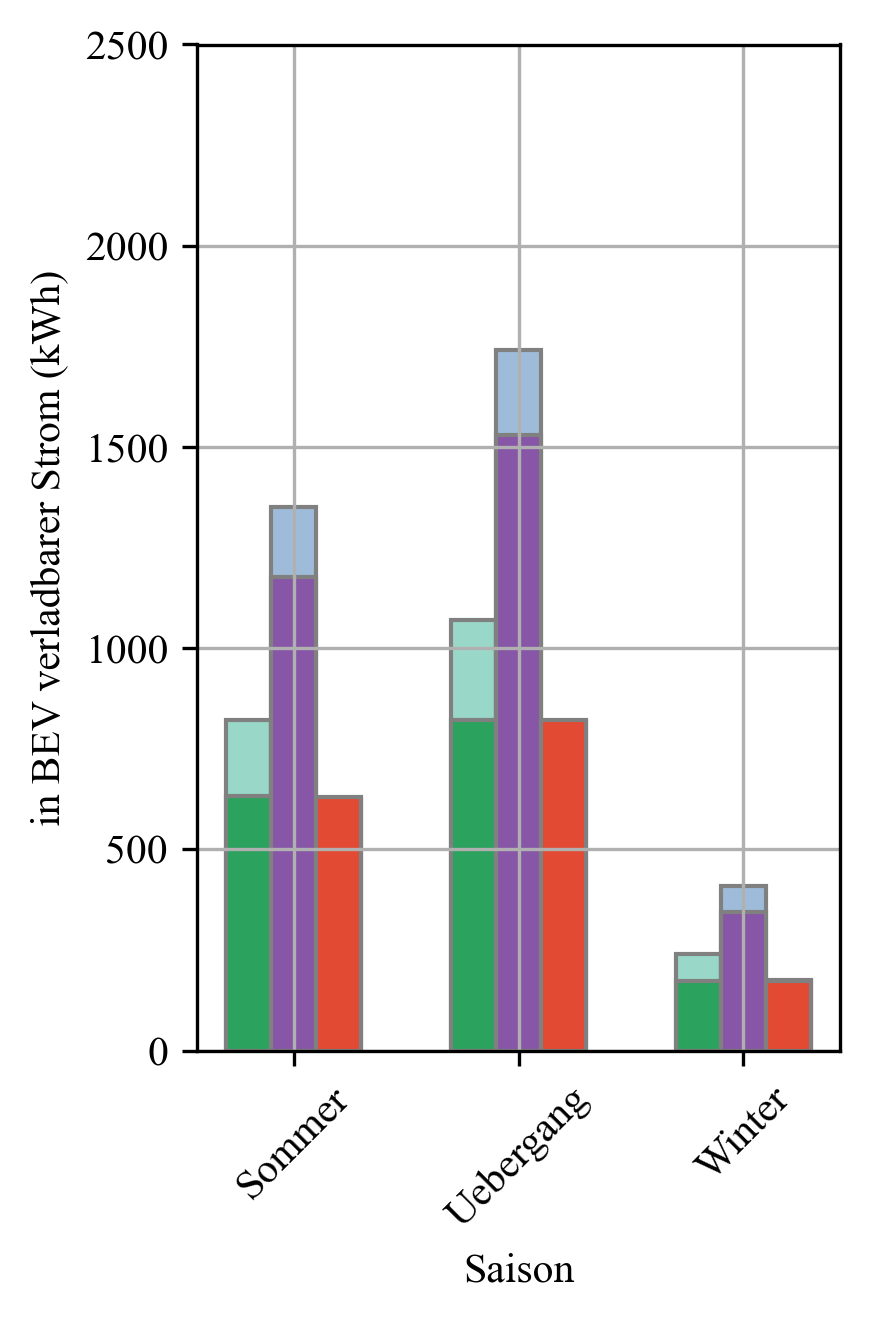

Vollzeit: Saison
Sommer       634.651681
Uebergang    798.137512
Winter       163.572006
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       1317.163089
Uebergang    1679.081883
Winter        484.058435
dtype: float64 kWh mit Batteriesupport
Teilzeit: Saison
Sommer       1179.646500
Uebergang    1496.713269
Winter        323.436150
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       1819.635864
Uebergang    2317.634070
Winter        605.091478
dtype: float64 kWh mit Batteriesupport
Wochenendpendler: Saison
Sommer       633.321175
Uebergang    796.905050
Winter       163.572006
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       642.930988
Uebergang    834.916602
Winter       227.737039
dtype: float64 kWh mit Batteriesupport


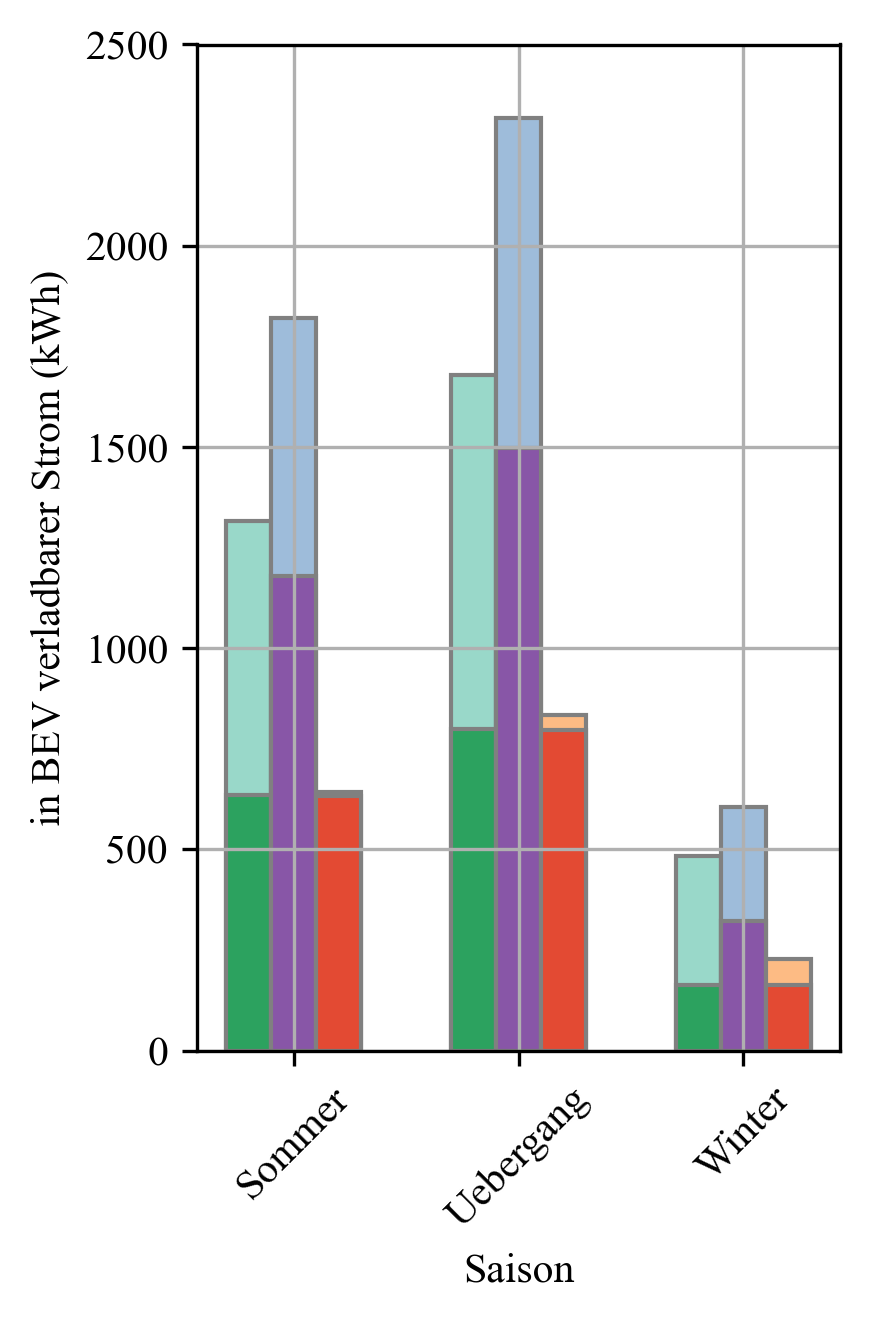

Vollzeit: Saison
Sommer       1620.013062
Uebergang    2145.019013
Winter        525.934613
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       1860.902764
Uebergang    2485.017666
Winter        636.874694
dtype: float64 kWh mit Batteriesupport
Teilzeit: Saison
Sommer       3134.768112
Uebergang    4078.056737
Winter        982.168700
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       3159.249452
Uebergang    4169.204791
Winter       1085.879169
dtype: float64 kWh mit Batteriesupport
Wochenendpendler: Saison
Sommer       1609.202475
Uebergang    2136.549937
Winter        525.934613
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       1594.257629
Uebergang    2122.456911
Winter        520.288081
dtype: float64 kWh mit Batteriesupport


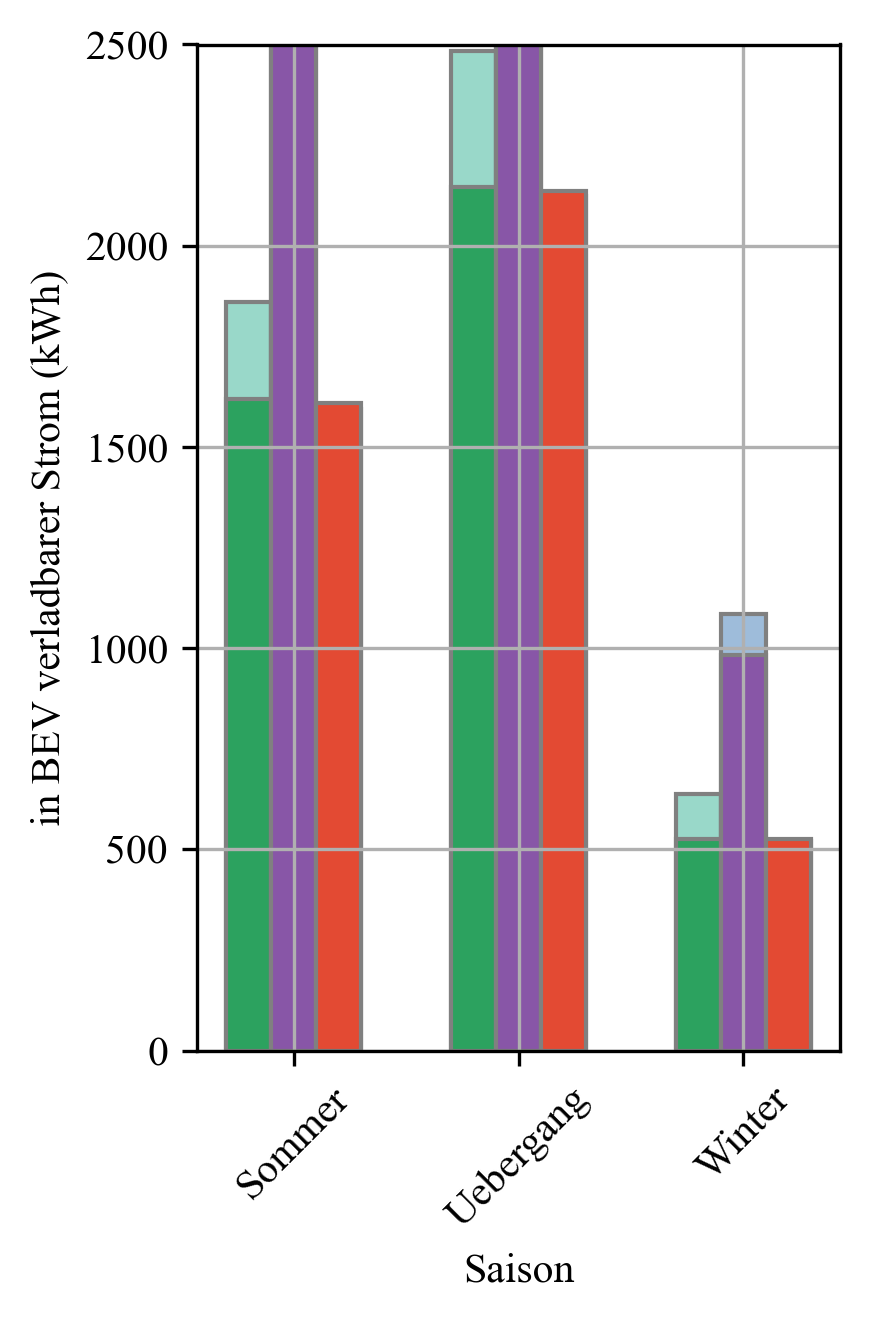

Vollzeit: Saison
Sommer       1620.013062
Uebergang    2136.556138
Winter        513.173338
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       2364.999736
Uebergang    3317.245848
Winter       1008.423442
dtype: float64 kWh mit Batteriesupport
Teilzeit: Saison
Sommer       3134.768112
Uebergang    4056.193700
Winter        959.523363
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       3567.802549
Uebergang    4837.726048
Winter       1403.769130
dtype: float64 kWh mit Batteriesupport
Wochenendpendler: Saison
Sommer       1609.202475
Uebergang    2128.087062
Winter        513.173338
Name: Geladen_Fahrzeug, dtype: float64 kWh, Saison
Sommer       1554.232966
Uebergang    2124.674225
Winter        547.471727
dtype: float64 kWh mit Batteriesupport


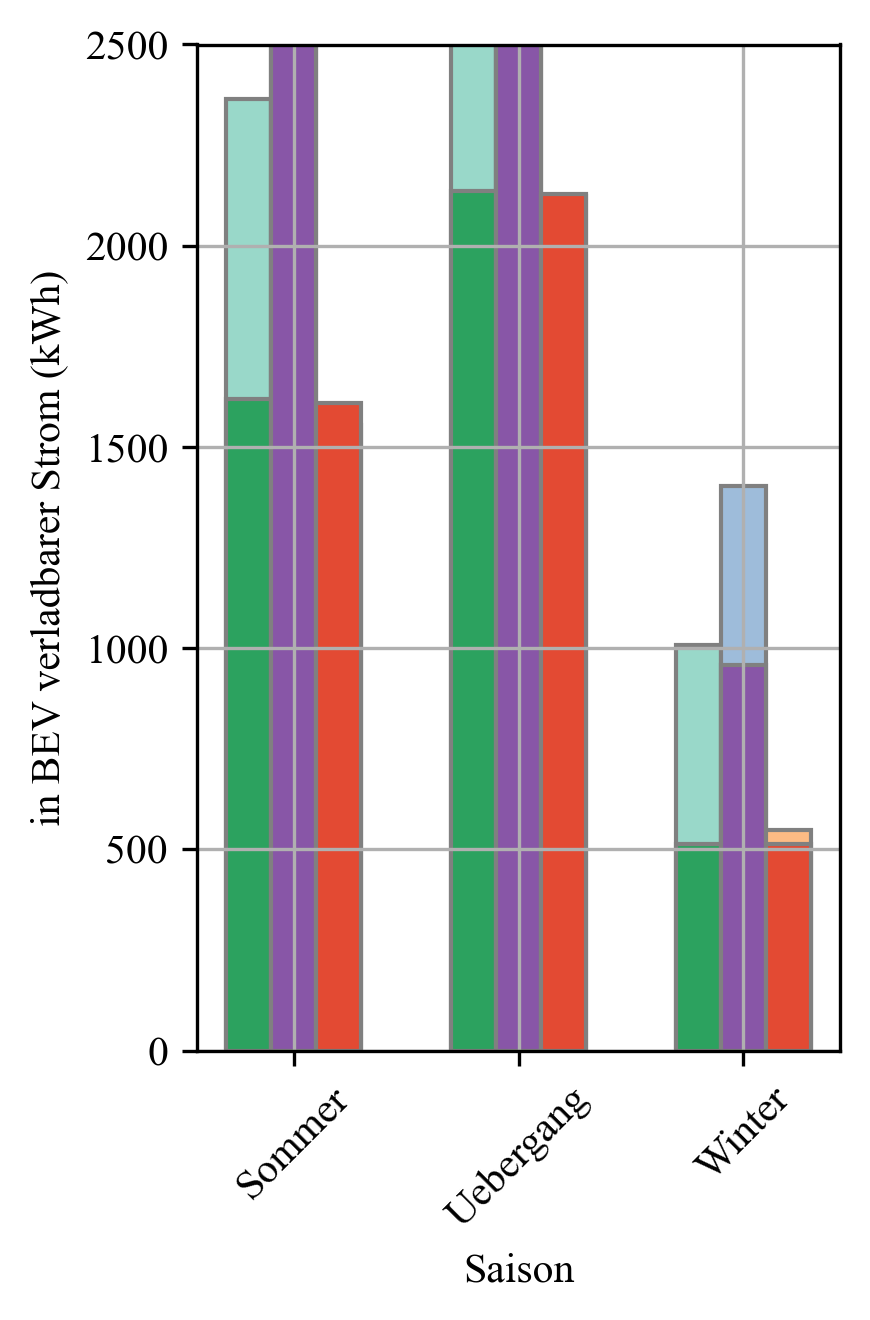

In [168]:
def plot_saison_charge(df_dict_vollzeit, df_dict_vollzeit_bat , df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, groese_pv_und_bat, title):
    df_voll = df_dict_vollzeit[groese_pv_und_bat].copy()
    df_voll_battery = df_dict_vollzeit_bat[groese_pv_und_bat].copy()
    

    df_teil = df_dict_teilzeit[groese_pv_und_bat].copy()
    df_teil_battery = df_dict_teilzeit_bat[groese_pv_und_bat].copy()
   

    df_woch = df_dict_wochenend[groese_pv_und_bat].copy()
    df_woch_battery = df_dict_wochenend_bat[groese_pv_und_bat].copy()

    # ----

    # Sicherstellen, dass die relevanten Spalten numerisch sind Vollzeit
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_voll[column] = pd.to_numeric(df_voll[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_voll_battery[column] = pd.to_numeric(df_voll_battery[column], errors='coerce')

    # Sicherstellen, dass die relevanten Spalten numerisch sind Teilzeit
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_teil[column] = pd.to_numeric(df_teil[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_teil_battery[column] = pd.to_numeric(df_teil_battery[column], errors='coerce')

    # Sicherstellen, dass die relevanten Spalten numerisch sind Wochenendpendler
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_woch[column] = pd.to_numeric(df_woch[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_woch_battery[column] = pd.to_numeric(df_woch_battery[column], errors='coerce')

    # ---- 
    # Monatliche Summen berechnen
    geladen_voll = df_voll.groupby(['Saison'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_voll_mit_batterie = df_voll_battery.groupby(['Saison'])['Geladen_Fahrzeug'].sum() / 1000 + df_voll_battery.groupby(['Saison'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh
    print("Vollzeit: "+str(geladen_voll)+" kWh, "+str(geladen_voll_mit_batterie)+" kWh mit Batteriesupport")

    # Monatliche Summen berechnen
    geladen_teil = df_teil.groupby(['Saison'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_teil_mit_batterie = df_teil_battery.groupby(['Saison'])['Geladen_Fahrzeug'].sum() / 1000 + df_teil_battery.groupby(['Saison'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh
    print("Teilzeit: "+str(geladen_teil)+" kWh, "+str(geladen_teil_mit_batterie)+" kWh mit Batteriesupport")

    # Monatliche Summen berechnen
    geladen_woch = df_woch.groupby(['Saison'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_woch_mit_batterie = df_woch_battery.groupby(['Saison'])['Geladen_Fahrzeug'].sum() / 1000 + df_woch_battery.groupby(['Saison'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh
    print("Wochenendpendler: "+str(geladen_woch)+" kWh, "+str(geladen_woch_mit_batterie)+" kWh mit Batteriesupport")

    

    plt.figure(figsize=(3, 4.5))

    # Schriftart passend setzen
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'

    bar_width = 0.2
    labels = geladen_voll.index
    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]


    plt.bar(r2, geladen_voll_mit_batterie, color='#99d8c9', width=bar_width, edgecolor='grey', label='Vollzeitkraft: in BEV ladbar mit Hausbatterie')
    plt.bar(r2, geladen_voll, color='#2ca25f', width=bar_width, edgecolor='grey', label='Vollzeitkraft: in BEV ladbar ohne Hausbatterie')

    plt.bar(r3, geladen_teil_mit_batterie, color='#9ebcda', width=bar_width, edgecolor='grey', label='Teilzeitkraft: in BEV ladbar mit Hausbatterie')
    plt.bar(r3, geladen_teil, color='#8856a7', width=bar_width, edgecolor='grey', label='Teilzeitkraft: in BEV ladbar ohne Hausbatterie')

    plt.bar(r4, geladen_woch_mit_batterie, color='#fdbb84', width=bar_width, edgecolor='grey', label='Wochenendpendler: in BEV ladbar mit Hausbatterie')
    plt.bar(r4, geladen_woch, color='#e34a33', width=bar_width, edgecolor='grey', label='Wochenendpendler: in BEV ladbar ohne Hausbatterie')

    labels = ['Sommer','Uebergang','Winter']

    # Plot erstellen
    # plt.title(title)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.ylim(0, 2500)
    plt.xlabel('Saison')
    plt.ylabel('in BEV verladbarer Strom (kWh)')
    plt.xticks([r + 0.4  for r in range(len(labels))], labels, rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_saison_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv10000_bat10000', "Monatsvergleich Ladeprofile 10kw 10kWh")
plot_saison_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv10000_bat20000', "Monatsvergleich Ladeprofile 10kw 20kWh")
plot_saison_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv20000_bat10000', "Monatsvergleich Ladeprofile 20kw 10kWh")
plot_saison_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv20000_bat20000', "Monatsvergleich Ladeprofile 20kw 20kWh")

In [ ]:
import unittest

class TestIstAutoZuHause(unittest.TestCase):
    def test_vollzeitkraft_arbeitszeit(self):
        dt = datetime(2020, 7, 27, 10, 0)  # Montag
        self.assertFalse(ist_auto_zu_hause(dt, 'Vollzeitkraft'))

    def test_vollzeitkraft_arbeitsweg(self):
        dt = datetime(2020, 7, 27, 6, 15)  # Montag
        self.assertTrue(ist_auto_zu_hause(dt, 'Vollzeitkraft'))

    def test_vollzeitkraft_nach_arbeit(self):
        dt = datetime(2020, 7, 27, 18, 0)  # Montag
        self.assertTrue(ist_auto_zu_hause(dt, 'Vollzeitkraft'))

    def test_vollzeitkraft_wochenende(self):
        dt = datetime(2020, 8, 1, 11, 0)  # Samstag
        self.assertFalse(ist_auto_zu_hause(dt, 'Vollzeitkraft'))

    def test_teilzeitkraft_arbeitszeit(self):
        dt = datetime(2020, 7, 28, 9, 0)  # Dienstag
        self.assertFalse(ist_auto_zu_hause(dt, 'Teilzeitkraft'))

    def test_teilzeitkraft_arbeitsweg(self):
        dt = datetime(2020, 7, 28, 7, 30)  # Dienstag
        self.assertTrue(ist_auto_zu_hause(dt, 'Teilzeitkraft'))

    def test_teilzeitkraft_nach_arbeit(self):
        dt = datetime(2020, 7, 28, 14, 0)  # Dienstag
        self.assertTrue(ist_auto_zu_hause(dt, 'Teilzeitkraft'))

    def test_teilzeitkraft_wochenende(self):
        dt = datetime(2020, 8, 1, 10, 30)  # Samstag
        self.assertFalse(ist_auto_zu_hause(dt, 'Teilzeitkraft'))

    def test_teilzeitkraft_wochenende(self):
        dt = datetime(2020, 8, 1, 9, 30)  # Samstag
        self.assertTrue(ist_auto_zu_hause(dt, 'Teilzeitkraft'))

    def test_wochenendpendler_arbeitswoche(self):
        dt = datetime(2020, 7, 29, 12, 0)  # Mittwoch
        self.assertFalse(ist_auto_zu_hause(dt, 'Wochenendpendler'))

    def test_wochenendpendler_freitagabend(self):
        dt = datetime(2020, 7, 31, 20, 0)  # Freitagabend
        self.assertFalse(ist_auto_zu_hause(dt, 'Wochenendpendler'))

    def test_wochenendpendler_wochenende(self):
        dt = datetime(2020, 8, 2, 15, 0)  # Sonntag
        self.assertTrue(ist_auto_zu_hause(dt, 'Wochenendpendler'))

# Führe die Tests in einem Jupyter Notebook aus
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestIstAutoZuHause))

...........
----------------------------------------------------------------------
Ran 11 tests in 0.006s

OK


<unittest.runner.TextTestResult run=11 errors=0 failures=0>

# Ladevolumen Tagesvergleich

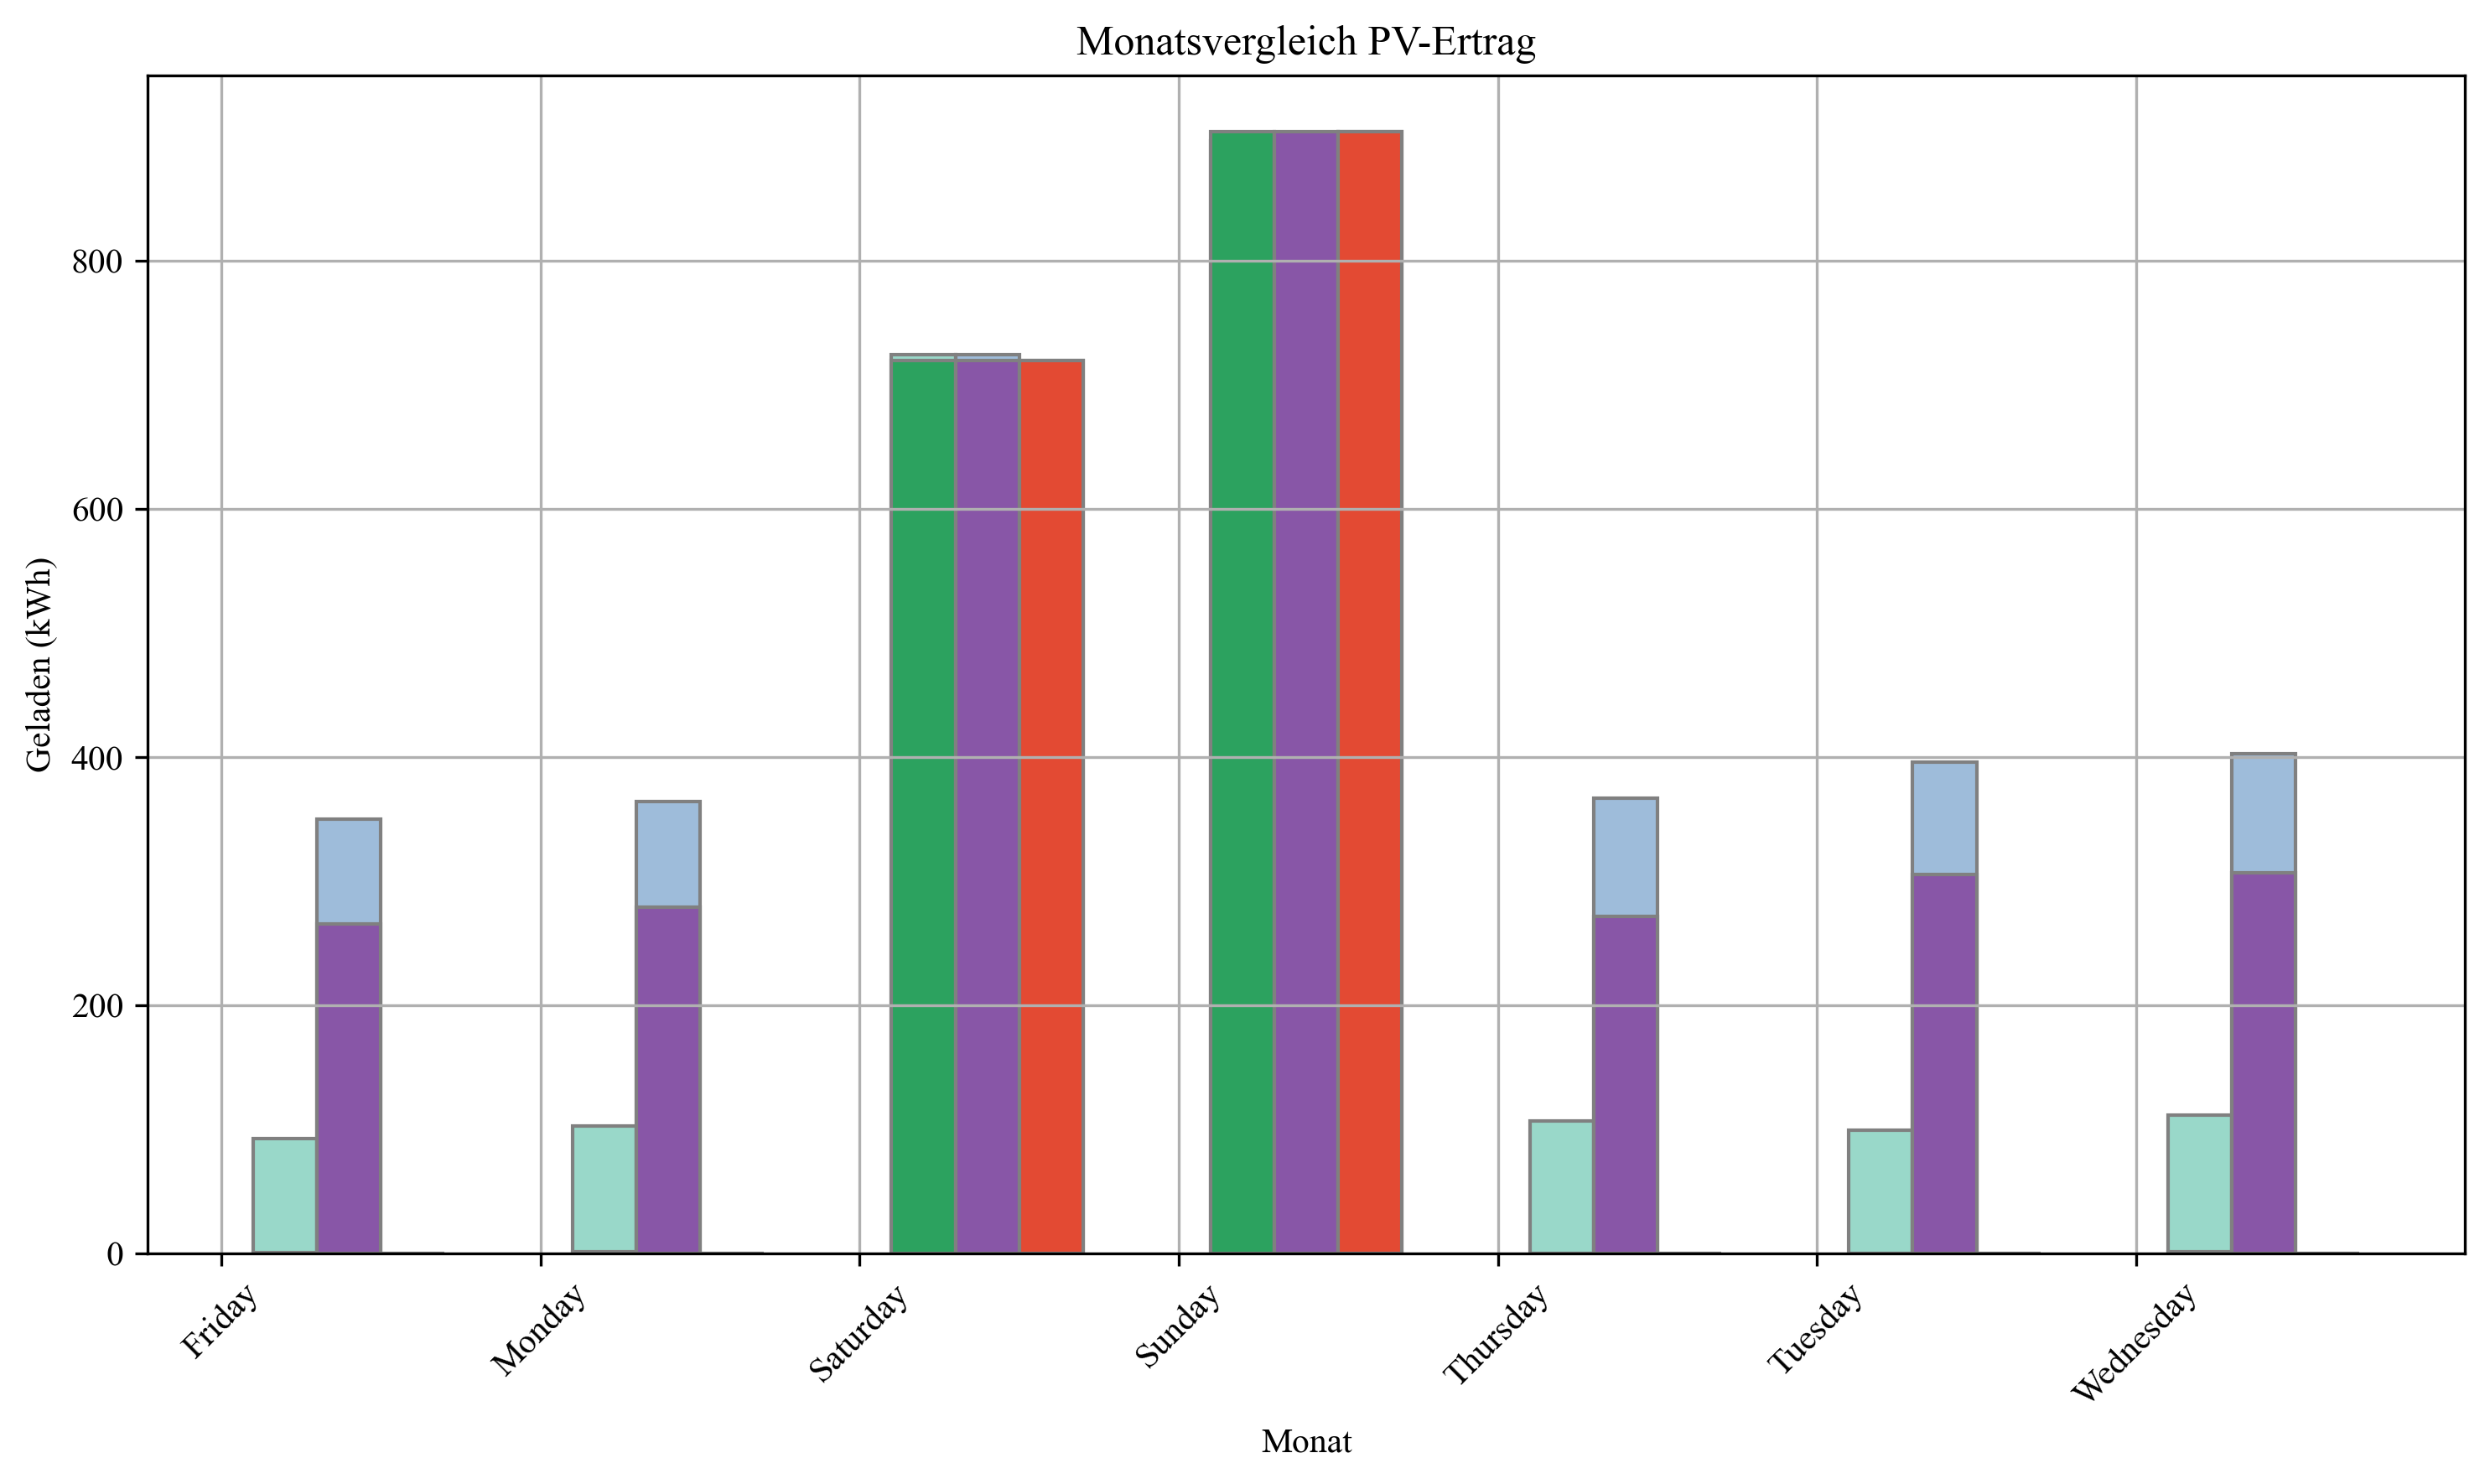

In [138]:
def plot_monthly_charge(df_dict_vollzeit, df_dict_vollzeit_bat , df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, groese_pv_und_bat, title):
    df_voll = df_dict_vollzeit[groese_pv_und_bat].copy()
    df_voll_battery = df_dict_vollzeit_bat[groese_pv_und_bat].copy()
    df_voll['weekday'] = pd.to_datetime(df_voll['Uhrzeit']).dt.day_name()
    df_voll_battery['weekday'] = pd.to_datetime(df_voll_battery['Uhrzeit']).dt.day_name()

    df_teil = df_dict_teilzeit[groese_pv_und_bat].copy()
    df_teil_battery = df_dict_teilzeit_bat[groese_pv_und_bat].copy()
    df_teil['weekday'] = pd.to_datetime(df_teil['Uhrzeit']).dt.day_name()
    df_teil_battery['weekday'] = pd.to_datetime(df_teil_battery['Uhrzeit']).dt.day_name()

    df_woch = df_dict_wochenend[groese_pv_und_bat].copy()
    df_woch_battery = df_dict_wochenend[groese_pv_und_bat].copy()
    df_woch['weekday'] = pd.to_datetime(df_woch['Uhrzeit']).dt.day_name()
    df_woch_battery['weekday'] = pd.to_datetime(df_woch_battery['Uhrzeit']).dt.day_name()

    # ----

    # Sicherstellen, dass die relevanten Spalten numerisch sind Vollzeit
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_voll[column] = pd.to_numeric(df_voll[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_voll_battery[column] = pd.to_numeric(df_voll_battery[column], errors='coerce')

    # Sicherstellen, dass die relevanten Spalten numerisch sind Teilzeit
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_teil[column] = pd.to_numeric(df_teil[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_teil_battery[column] = pd.to_numeric(df_teil_battery[column], errors='coerce')

    # Sicherstellen, dass die relevanten Spalten numerisch sind Wochenendpendler
    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Lastprofil']:
        df_woch[column] = pd.to_numeric(df_woch[column], errors='coerce')

    for column in ['PV_Ertrag', 'Einspeisung', 'Netzbezug', 'Geladen_Fahrzeug', 'Geladen_Fahrzeug_Batterie', 'Lastprofil']:
        df_woch_battery[column] = pd.to_numeric(df_woch_battery[column], errors='coerce')

    # ---- 
    # Monatliche Summen berechnen
    geladen_voll = df_voll.groupby(['weekday'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_voll_mit_batterie = df_voll_battery.groupby(['weekday'])['Geladen_Fahrzeug'].sum() / 1000 + df_voll_battery.groupby(['weekday'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh
    #print(pv_sum)

    # Monatliche Summen berechnen
    geladen_teil = df_teil.groupby(['weekday'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_teil_mit_batterie = df_teil_battery.groupby(['weekday'])['Geladen_Fahrzeug'].sum() / 1000 + df_teil_battery.groupby(['weekday'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh

    # Monatliche Summen berechnen
    geladen_woch = df_woch.groupby(['weekday'])['Geladen_Fahrzeug'].sum() / 1000  # Umrechnung von Wh in kWh
    geladen_woch_mit_batterie = df_woch_battery.groupby(['weekday'])['Geladen_Fahrzeug'].sum() / 1000 + df_woch_battery.groupby(['weekday'])['Geladen_Fahrzeug_Batterie'].sum() / 1000  # Umrechnung von Wh in kWh



    plt.figure(figsize=(10, 6))

    # Schriftart passend setzen
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'

    bar_width = 0.2
    labels = geladen_voll.index
    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]


    plt.bar(r2, geladen_voll_mit_batterie, color='#99d8c9', width=bar_width, edgecolor='grey', label='Vollzeitkraft: geladen_fahrzeug_mit_batterie_sum')
    plt.bar(r2, geladen_voll, color='#2ca25f', width=bar_width, edgecolor='grey', label='Vollzeitkraft: geladen_fahrzeug_sum')

    plt.bar(r3, geladen_teil_mit_batterie, color='#9ebcda', width=bar_width, edgecolor='grey', label='Vollzeitkraft: geladen_fahrzeug_mit_batterie_sum')
    plt.bar(r3, geladen_teil, color='#8856a7', width=bar_width, edgecolor='grey', label='Vollzeitkraft: geladen_fahrzeug_sum')

    plt.bar(r4, geladen_woch_mit_batterie, color='#fdbb84', width=bar_width, edgecolor='grey', label='Vollzeitkraft: geladen_fahrzeug_mit_batterie_sum')
    plt.bar(r4, geladen_woch, color='#e34a33', width=bar_width, edgecolor='grey', label='Vollzeitkraft: geladen_fahrzeug_sum')

    # Plot erstellen
    plt.title(title)
    plt.xlabel('Monat')
    plt.ylabel('Geladen (kWh)')
    plt.xticks([r for r in range(len(labels))], labels, rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_monthly_charge(df_dict_vollzeit, df_dict_vollzeit_bat, df_dict_teilzeit, df_dict_teilzeit_bat, df_dict_wochenend, df_dict_wochenend_bat, 'pv10000_bat10000', "Monatsvergleich PV-Ertrag")